In [1]:
import warnings 
warnings.filterwarnings("ignore")

from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LabelFilterd,
    Lambdad,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import numpy as np

import itk

import sys

import site
site.addsitedir('../../ARGUS')
from ARGUSUtils_Transforms import *

In [2]:
if False: #len(sys.argv) == 3:
    device_num = int(sys.argv[1])
    num_devices = int(sys.argv[2])
    print("Using device", str(device_num),"of", str(num_devices))
else:
    print("Device number assumed to be 0")
    device_num = 0
    num_devices = 1


img1_dir = "../../Data/VFoldData/BAMC-PTX*Sliding-Annotations-Linear/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_?????.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.extruded-overlay-NRS.nii.gz')))

num_folds = 15

num_classes = 4

net_dims = 2
net_in_channels = 4
max_epochs = 1000
net_channels=(32, 64, 64, 32, 32)
net_strides=(2, 2, 2, 2)

num_workers_tr = 1
batch_size_tr = 16
num_workers_vl = 1
batch_size_vl = 4

num_slices = 32
size_x = 320
size_y = 320


model_filename_base = "./results/BAMC_PTX_ARUNet-StdDevExtended-ExtrudedNRS"

num_images = len(all_images)
print("Num images / labels =", num_images, len(all_labels))

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)

Device number assumed to be 0
Num images / labels = 62 62


In [3]:
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

53 4 5
53 5 4
54 4 4
54 4 4
54 4 4
55 4 3
55 3 4
54 4 4
54 4 4
54 4 4
53 4 5
53 5 4
53 4 5
53 5 4
54 4 4


../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/081s_iimage_3320344386805_clean.nii.gz
../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/081s_iimage_3320344386805_clean.extruded-overlay-NRS.nii.gz


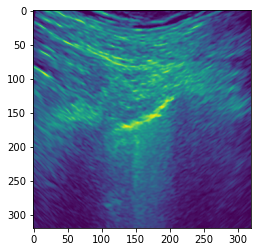

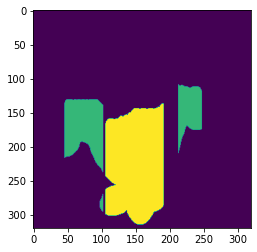

In [4]:
imgnum = 40 #10 for ns, 0 for s

print(train_files[0][imgnum]["image"])
print(train_files[0][imgnum]["label"])

img = itk.imread(train_files[0][imgnum]["image"])
arrimg = itk.GetArrayFromImage(img)
img = itk.imread(train_files[0][imgnum]["label"])
arrlbl = itk.GetArrayFromImage(img)

plt.subplots()
plt.imshow(arrimg[0,:,:])
plt.subplots()
plt.imshow(arrlbl[0,:,:])

In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        SpatialCropd(
            roi_start=[0,0,1],
            roi_end=[320,320,61],
            keys=["image", "label"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slices,1],
            axis=0,
            reduce_to_statistics=[True,False],
            extended=True,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        RandZoomd(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keep_size=True,
            mode=['bilinear', 'nearest'],
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        SpatialCropd(
            roi_start=[0,0,1],
            roi_end=[320,320,61],
            keys=["image", "label"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slices,1],
            axis=0,
            reduce_to_statistics=[True,False],
            extended=True,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

In [6]:
train_ds = [CacheDataset(data=train_files[i], transform=train_transforms,cache_rate=1.0, num_workers=num_workers_tr)
            for i in range(num_folds)]
train_loader = [DataLoader(train_ds[i], batch_size=batch_size_tr, shuffle=True, num_workers=num_workers_tr) 
                for i in range(num_folds)]

val_ds = [CacheDataset(data=val_files[i], transform=val_transforms, cache_rate=1.0, num_workers=num_workers_vl)
          for i in range(num_folds)]
val_loader = [DataLoader(val_ds[i], batch_size=batch_size_vl, num_workers=num_workers_vl)
              for i in range(num_folds)]

Loading dataset: 100%|████████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


torch.Size([4, 4, 320, 320])
torch.Size([4, 320, 320])
image shape: torch.Size([4, 320, 320]), label shape: torch.Size([1, 320, 320])


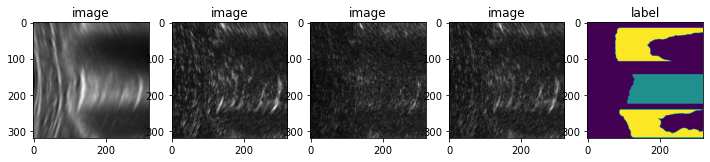

tensor(0.) tensor(2.)


In [7]:
imgnum = 0
check_data = first(val_loader[0])
image, label = (check_data["image"][imgnum], check_data["label"][imgnum])
print(check_data["image"].shape)
print(image.shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 5, 1)
plt.title("image")
plt.imshow(image[0, :, :], cmap="gray")
plt.subplot(1, 5, 2)
plt.title("image")
plt.imshow(image[1, :, :], cmap="gray")
plt.subplot(1, 5, 3)
plt.title("image")
plt.imshow(image[2, :, :], cmap="gray")
plt.subplot(1, 5, 4)
plt.title("image")
plt.imshow(image[3, :, :], cmap="gray")
plt.subplot(1, 5, 5)
plt.title("label")
plt.imshow(label[0, :, :])
plt.show()
print(label.min(), label.max())

In [8]:
device = torch.device("cuda:"+str(device_num))

In [9]:
def vfold_train(vfold_num, train_loader, val_loader):
    model = UNet(
        dimensions=net_dims,
        in_channels=net_in_channels,
        out_channels=num_classes,
        channels=net_channels,
        strides=net_strides,
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)
    dice_metric = DiceMetric(include_background=False, reduction="mean")

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"{vfold_num}: epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
                  f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"{vfold_num} epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (size_x, size_y)
                    sw_batch_size = batch_size_vl
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if epoch > 100:
                    metric = (metric_values[-1]+metric_values[-2])/2
                    if metric > best_metric:
                        best_metric = metric
                        best_metric_epoch = epoch + 1
                        torch.save(model.state_dict(), model_filename_base+'.best_model.vfold_'+str(vfold_num)+'.pth')
                        print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )
                torch.save(model.state_dict(), model_filename_base+'.last_model.vfold_'+str(vfold_num)+'.pth')

    np.save(model_filename_base+"_loss_"+str(vfold_num)+".npy", epoch_loss_values)
    np.save(model_filename_base+"_val_dice_"+str(vfold_num)+".npy", metric_values)

    

In [ ]:
for i in range(4,num_folds,num_devices):
        vfold_train(i, train_loader[i], val_loader[i])

----------
0: epoch 1/1000
1/0, train_loss: 0.8326
2/0, train_loss: 0.8331
3/0, train_loss: 0.8270
4/0, train_loss: 0.8138
0 epoch 1 average loss: 0.8266
----------
0: epoch 2/1000
1/0, train_loss: 0.8184
2/0, train_loss: 0.8233
3/0, train_loss: 0.8072
4/0, train_loss: 0.8103
0 epoch 2 average loss: 0.8148
current epoch: 2 current mean dice: 0.1144
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 3/1000
1/0, train_loss: 0.8017
2/0, train_loss: 0.7987
3/0, train_loss: 0.8112
4/0, train_loss: 0.7975
0 epoch 3 average loss: 0.8023
----------
0: epoch 4/1000
1/0, train_loss: 0.7941
2/0, train_loss: 0.7975
3/0, train_loss: 0.7949
4/0, train_loss: 0.7983
0 epoch 4 average loss: 0.7962
current epoch: 4 current mean dice: 0.1189
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 5/1000
1/0, train_loss: 0.7927
2/0, train_loss: 0.7952
3/0, train_loss: 0.7796
4/0, train_loss: 0.7815
0 epoch 5 average loss: 0.7873
----------
0: epoch 6/1000
1/0, train_loss: 0.7805
2/0, train_loss: 0.

1/0, train_loss: 0.6520
2/0, train_loss: 0.6521
3/0, train_loss: 0.6642
4/0, train_loss: 0.6674
0 epoch 43 average loss: 0.6589
----------
0: epoch 44/1000
1/0, train_loss: 0.6650
2/0, train_loss: 0.6430
3/0, train_loss: 0.6457
4/0, train_loss: 0.6581
0 epoch 44 average loss: 0.6529
current epoch: 44 current mean dice: 0.5716
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 45/1000
1/0, train_loss: 0.6627
2/0, train_loss: 0.6274
3/0, train_loss: 0.6602
4/0, train_loss: 0.6796
0 epoch 45 average loss: 0.6575
----------
0: epoch 46/1000
1/0, train_loss: 0.6478
2/0, train_loss: 0.6614
3/0, train_loss: 0.6560
4/0, train_loss: 0.6150
0 epoch 46 average loss: 0.6450
current epoch: 46 current mean dice: 0.5407
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 47/1000
1/0, train_loss: 0.6546
2/0, train_loss: 0.6590
3/0, train_loss: 0.6506
4/0, train_loss: 0.6193
0 epoch 47 average loss: 0.6459
----------
0: epoch 48/1000
1/0, train_loss: 0.6462
2/0, train_loss: 0.6538
3/0, train

1/0, train_loss: 0.5960
2/0, train_loss: 0.6245
3/0, train_loss: 0.5714
4/0, train_loss: 0.6216
0 epoch 85 average loss: 0.6034
----------
0: epoch 86/1000
1/0, train_loss: 0.5916
2/0, train_loss: 0.6071
3/0, train_loss: 0.5917
4/0, train_loss: 0.5706
0 epoch 86 average loss: 0.5903
current epoch: 86 current mean dice: 0.5958
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 87/1000
1/0, train_loss: 0.5856
2/0, train_loss: 0.6082
3/0, train_loss: 0.6021
4/0, train_loss: 0.5535
0 epoch 87 average loss: 0.5874
----------
0: epoch 88/1000
1/0, train_loss: 0.5627
2/0, train_loss: 0.6064
3/0, train_loss: 0.6130
4/0, train_loss: 0.6236
0 epoch 88 average loss: 0.6014
current epoch: 88 current mean dice: 0.6498
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 89/1000
1/0, train_loss: 0.6081
2/0, train_loss: 0.5942
3/0, train_loss: 0.5831
4/0, train_loss: 0.5768
0 epoch 89 average loss: 0.5905
----------
0: epoch 90/1000
1/0, train_loss: 0.6001
2/0, train_loss: 0.6034
3/0, train

1/0, train_loss: 0.5960
2/0, train_loss: 0.5385
3/0, train_loss: 0.5421
4/0, train_loss: 0.5419
0 epoch 126 average loss: 0.5546
current epoch: 126 current mean dice: 0.6208
best mean dice: 0.6403 at epoch: 118
----------
0: epoch 127/1000
1/0, train_loss: 0.5381
2/0, train_loss: 0.5631
3/0, train_loss: 0.5651
4/0, train_loss: 0.5503
0 epoch 127 average loss: 0.5541
----------
0: epoch 128/1000
1/0, train_loss: 0.5681
2/0, train_loss: 0.5432
3/0, train_loss: 0.5406
4/0, train_loss: 0.5748
0 epoch 128 average loss: 0.5567
current epoch: 128 current mean dice: 0.5821
best mean dice: 0.6403 at epoch: 118
----------
0: epoch 129/1000
1/0, train_loss: 0.5590
2/0, train_loss: 0.5604
3/0, train_loss: 0.5548
4/0, train_loss: 0.5546
0 epoch 129 average loss: 0.5572
----------
0: epoch 130/1000
1/0, train_loss: 0.5618
2/0, train_loss: 0.5407
3/0, train_loss: 0.5501
4/0, train_loss: 0.5789
0 epoch 130 average loss: 0.5579
current epoch: 130 current mean dice: 0.5793
best mean dice: 0.6403 at epoc

1/0, train_loss: 0.5007
2/0, train_loss: 0.5061
3/0, train_loss: 0.5371
4/0, train_loss: 0.5028
0 epoch 167 average loss: 0.5117
----------
0: epoch 168/1000
1/0, train_loss: 0.5389
2/0, train_loss: 0.5091
3/0, train_loss: 0.5145
4/0, train_loss: 0.5028
0 epoch 168 average loss: 0.5163
current epoch: 168 current mean dice: 0.6654
best mean dice: 0.6657 at epoch: 166
----------
0: epoch 169/1000
1/0, train_loss: 0.5226
2/0, train_loss: 0.5153
3/0, train_loss: 0.4960
4/0, train_loss: 0.5680
0 epoch 169 average loss: 0.5255
----------
0: epoch 170/1000
1/0, train_loss: 0.5229
2/0, train_loss: 0.5033
3/0, train_loss: 0.5136
4/0, train_loss: 0.5633
0 epoch 170 average loss: 0.5258
current epoch: 170 current mean dice: 0.6423
best mean dice: 0.6657 at epoch: 166
----------
0: epoch 171/1000
1/0, train_loss: 0.5042
2/0, train_loss: 0.5138
3/0, train_loss: 0.5325
4/0, train_loss: 0.5194
0 epoch 171 average loss: 0.5174
----------
0: epoch 172/1000
1/0, train_loss: 0.5030
2/0, train_loss: 0.525

2/0, train_loss: 0.4672
3/0, train_loss: 0.4545
4/0, train_loss: 0.5340
0 epoch 208 average loss: 0.4887
current epoch: 208 current mean dice: 0.6528
best mean dice: 0.6745 at epoch: 188
----------
0: epoch 209/1000
1/0, train_loss: 0.4656
2/0, train_loss: 0.4865
3/0, train_loss: 0.4951
4/0, train_loss: 0.4756
0 epoch 209 average loss: 0.4807
----------
0: epoch 210/1000
1/0, train_loss: 0.4657
2/0, train_loss: 0.4705
3/0, train_loss: 0.5040
4/0, train_loss: 0.4640
0 epoch 210 average loss: 0.4760
current epoch: 210 current mean dice: 0.6181
best mean dice: 0.6745 at epoch: 188
----------
0: epoch 211/1000
1/0, train_loss: 0.4732
2/0, train_loss: 0.4587
3/0, train_loss: 0.4993
4/0, train_loss: 0.5014
0 epoch 211 average loss: 0.4831
----------
0: epoch 212/1000
1/0, train_loss: 0.5018
2/0, train_loss: 0.4719
3/0, train_loss: 0.4745
4/0, train_loss: 0.4548
0 epoch 212 average loss: 0.4758
current epoch: 212 current mean dice: 0.6210
best mean dice: 0.6745 at epoch: 188
----------
0: epo

1/0, train_loss: 0.4455
2/0, train_loss: 0.4518
3/0, train_loss: 0.4536
4/0, train_loss: 0.4645
0 epoch 249 average loss: 0.4539
----------
0: epoch 250/1000
1/0, train_loss: 0.4362
2/0, train_loss: 0.4521
3/0, train_loss: 0.4397
4/0, train_loss: 0.5421
0 epoch 250 average loss: 0.4675
current epoch: 250 current mean dice: 0.6481
best mean dice: 0.6763 at epoch: 232
----------
0: epoch 251/1000
1/0, train_loss: 0.4631
2/0, train_loss: 0.4083
3/0, train_loss: 0.4603
4/0, train_loss: 0.4729
0 epoch 251 average loss: 0.4512
----------
0: epoch 252/1000
1/0, train_loss: 0.4519
2/0, train_loss: 0.4326
3/0, train_loss: 0.4399
4/0, train_loss: 0.4679
0 epoch 252 average loss: 0.4480
current epoch: 252 current mean dice: 0.6503
best mean dice: 0.6763 at epoch: 232
----------
0: epoch 253/1000
1/0, train_loss: 0.4346
2/0, train_loss: 0.4384
3/0, train_loss: 0.4531
4/0, train_loss: 0.4641
0 epoch 253 average loss: 0.4475
----------
0: epoch 254/1000
1/0, train_loss: 0.4406
2/0, train_loss: 0.442

3/0, train_loss: 0.4205
4/0, train_loss: 0.4319
0 epoch 290 average loss: 0.4300
current epoch: 290 current mean dice: 0.6551
best mean dice: 0.6949 at epoch: 282
----------
0: epoch 291/1000
1/0, train_loss: 0.4237
2/0, train_loss: 0.4237
3/0, train_loss: 0.4362
4/0, train_loss: 0.4900
0 epoch 291 average loss: 0.4434
----------
0: epoch 292/1000
1/0, train_loss: 0.4530
2/0, train_loss: 0.4287
3/0, train_loss: 0.4187
4/0, train_loss: 0.4194
0 epoch 292 average loss: 0.4299
current epoch: 292 current mean dice: 0.6277
best mean dice: 0.6949 at epoch: 282
----------
0: epoch 293/1000
1/0, train_loss: 0.4468
2/0, train_loss: 0.4160
3/0, train_loss: 0.4162
4/0, train_loss: 0.4324
0 epoch 293 average loss: 0.4279
----------
0: epoch 294/1000
1/0, train_loss: 0.4384
2/0, train_loss: 0.4176
3/0, train_loss: 0.4346
4/0, train_loss: 0.4446
0 epoch 294 average loss: 0.4338
current epoch: 294 current mean dice: 0.6277
best mean dice: 0.6949 at epoch: 282
----------
0: epoch 295/1000
1/0, train_l

3/0, train_loss: 0.4278
4/0, train_loss: 0.4413
0 epoch 331 average loss: 0.4151
----------
0: epoch 332/1000
1/0, train_loss: 0.4274
2/0, train_loss: 0.3972
3/0, train_loss: 0.3960
4/0, train_loss: 0.4190
0 epoch 332 average loss: 0.4099
current epoch: 332 current mean dice: 0.6793
best mean dice: 0.6949 at epoch: 282
----------
0: epoch 333/1000
1/0, train_loss: 0.3892
2/0, train_loss: 0.4274
3/0, train_loss: 0.4167
4/0, train_loss: 0.3957
0 epoch 333 average loss: 0.4073
----------
0: epoch 334/1000
1/0, train_loss: 0.4004
2/0, train_loss: 0.4061
3/0, train_loss: 0.4101
4/0, train_loss: 0.4355
0 epoch 334 average loss: 0.4130
current epoch: 334 current mean dice: 0.6928
best mean dice: 0.6949 at epoch: 282
----------
0: epoch 335/1000
1/0, train_loss: 0.3965
2/0, train_loss: 0.3889
3/0, train_loss: 0.4384
4/0, train_loss: 0.4175
0 epoch 335 average loss: 0.4103
----------
0: epoch 336/1000
1/0, train_loss: 0.3964
2/0, train_loss: 0.4139
3/0, train_loss: 0.4249
4/0, train_loss: 0.467

0 epoch 372 average loss: 0.3930
current epoch: 372 current mean dice: 0.6647
best mean dice: 0.6975 at epoch: 360
----------
0: epoch 373/1000
1/0, train_loss: 0.4097
2/0, train_loss: 0.3851
3/0, train_loss: 0.3942
4/0, train_loss: 0.3757
0 epoch 373 average loss: 0.3912
----------
0: epoch 374/1000
1/0, train_loss: 0.3836
2/0, train_loss: 0.3780
3/0, train_loss: 0.4228
4/0, train_loss: 0.3893
0 epoch 374 average loss: 0.3934
current epoch: 374 current mean dice: 0.6135
best mean dice: 0.6975 at epoch: 360
----------
0: epoch 375/1000
1/0, train_loss: 0.4066
2/0, train_loss: 0.3844
3/0, train_loss: 0.4089
4/0, train_loss: 0.3778
0 epoch 375 average loss: 0.3945
----------
0: epoch 376/1000
1/0, train_loss: 0.4017
2/0, train_loss: 0.3994
3/0, train_loss: 0.3762
4/0, train_loss: 0.3663
0 epoch 376 average loss: 0.3859
current epoch: 376 current mean dice: 0.6229
best mean dice: 0.6975 at epoch: 360
----------
0: epoch 377/1000
1/0, train_loss: 0.4011
2/0, train_loss: 0.3849
3/0, train_l

0 epoch 413 average loss: 0.4182
----------
0: epoch 414/1000
1/0, train_loss: 0.4068
2/0, train_loss: 0.3831
3/0, train_loss: 0.3715
4/0, train_loss: 0.3916
0 epoch 414 average loss: 0.3882
current epoch: 414 current mean dice: 0.6911
best mean dice: 0.7117 at epoch: 388
----------
0: epoch 415/1000
1/0, train_loss: 0.4054
2/0, train_loss: 0.3769
3/0, train_loss: 0.3824
4/0, train_loss: 0.3966
0 epoch 415 average loss: 0.3903
----------
0: epoch 416/1000
1/0, train_loss: 0.3939
2/0, train_loss: 0.3581
3/0, train_loss: 0.3965
4/0, train_loss: 0.4069
0 epoch 416 average loss: 0.3889
current epoch: 416 current mean dice: 0.6776
best mean dice: 0.7117 at epoch: 388
----------
0: epoch 417/1000
1/0, train_loss: 0.3778
2/0, train_loss: 0.3739
3/0, train_loss: 0.3904
4/0, train_loss: 0.4014
0 epoch 417 average loss: 0.3859
----------
0: epoch 418/1000
1/0, train_loss: 0.3875
2/0, train_loss: 0.3570
3/0, train_loss: 0.4129
4/0, train_loss: 0.3578
0 epoch 418 average loss: 0.3788
current epoch

1/0, train_loss: 0.3654
2/0, train_loss: 0.3844
3/0, train_loss: 0.3730
4/0, train_loss: 0.3994
0 epoch 455 average loss: 0.3805
----------
0: epoch 456/1000
1/0, train_loss: 0.3748
2/0, train_loss: 0.3829
3/0, train_loss: 0.3676
4/0, train_loss: 0.3798
0 epoch 456 average loss: 0.3763
current epoch: 456 current mean dice: 0.6749
best mean dice: 0.7117 at epoch: 388
----------
0: epoch 457/1000
1/0, train_loss: 0.3670
2/0, train_loss: 0.3891
3/0, train_loss: 0.3861
4/0, train_loss: 0.4382
0 epoch 457 average loss: 0.3951
----------
0: epoch 458/1000
1/0, train_loss: 0.3803
2/0, train_loss: 0.3912
3/0, train_loss: 0.3594
4/0, train_loss: 0.3690
0 epoch 458 average loss: 0.3750
current epoch: 458 current mean dice: 0.6870
best mean dice: 0.7117 at epoch: 388
----------
0: epoch 459/1000
1/0, train_loss: 0.3644
2/0, train_loss: 0.3816
3/0, train_loss: 0.3651
4/0, train_loss: 0.3818
0 epoch 459 average loss: 0.3732
----------
0: epoch 460/1000
1/0, train_loss: 0.3699
2/0, train_loss: 0.372

3/0, train_loss: 0.3409
4/0, train_loss: 0.4200
0 epoch 496 average loss: 0.3768
current epoch: 496 current mean dice: 0.6406
best mean dice: 0.7128 at epoch: 492
----------
0: epoch 497/1000
1/0, train_loss: 0.3534
2/0, train_loss: 0.3660
3/0, train_loss: 0.3849
4/0, train_loss: 0.4730
0 epoch 497 average loss: 0.3943
----------
0: epoch 498/1000
1/0, train_loss: 0.3917
2/0, train_loss: 0.3868
3/0, train_loss: 0.3622
4/0, train_loss: 0.3562
0 epoch 498 average loss: 0.3742
current epoch: 498 current mean dice: 0.5390
best mean dice: 0.7128 at epoch: 492
----------
0: epoch 499/1000
1/0, train_loss: 0.3884
2/0, train_loss: 0.3800
3/0, train_loss: 0.3927
4/0, train_loss: 0.3656
0 epoch 499 average loss: 0.3817
----------
0: epoch 500/1000
1/0, train_loss: 0.3813
2/0, train_loss: 0.3687
3/0, train_loss: 0.3783
4/0, train_loss: 0.3858
0 epoch 500 average loss: 0.3785
current epoch: 500 current mean dice: 0.5614
best mean dice: 0.7128 at epoch: 492
----------
0: epoch 501/1000
1/0, train_l

3/0, train_loss: 0.3538
4/0, train_loss: 0.3446
0 epoch 537 average loss: 0.3574
----------
0: epoch 538/1000
1/0, train_loss: 0.3504
2/0, train_loss: 0.3576
3/0, train_loss: 0.4060
4/0, train_loss: 0.3344
0 epoch 538 average loss: 0.3621
current epoch: 538 current mean dice: 0.6986
best mean dice: 0.7128 at epoch: 492
----------
0: epoch 539/1000
1/0, train_loss: 0.3558
2/0, train_loss: 0.3584
3/0, train_loss: 0.3959
4/0, train_loss: 0.3540
0 epoch 539 average loss: 0.3660
----------
0: epoch 540/1000
1/0, train_loss: 0.3644
2/0, train_loss: 0.3591
3/0, train_loss: 0.3657
4/0, train_loss: 0.3361
0 epoch 540 average loss: 0.3563
current epoch: 540 current mean dice: 0.6361
best mean dice: 0.7128 at epoch: 492
----------
0: epoch 541/1000
1/0, train_loss: 0.3730
2/0, train_loss: 0.3652
3/0, train_loss: 0.3507
4/0, train_loss: 0.3757
0 epoch 541 average loss: 0.3661
----------
0: epoch 542/1000
1/0, train_loss: 0.3358
2/0, train_loss: 0.3605
3/0, train_loss: 0.3711
4/0, train_loss: 0.420

current epoch: 578 current mean dice: 0.6676
best mean dice: 0.7128 at epoch: 492
----------
0: epoch 579/1000
1/0, train_loss: 0.3772
2/0, train_loss: 0.3385
3/0, train_loss: 0.3677
4/0, train_loss: 0.3565
0 epoch 579 average loss: 0.3600
----------
0: epoch 580/1000
1/0, train_loss: 0.3451
2/0, train_loss: 0.3356
3/0, train_loss: 0.3776
4/0, train_loss: 0.3778
0 epoch 580 average loss: 0.3590
current epoch: 580 current mean dice: 0.6541
best mean dice: 0.7128 at epoch: 492
----------
0: epoch 581/1000
1/0, train_loss: 0.3677
2/0, train_loss: 0.3364
3/0, train_loss: 0.3786
4/0, train_loss: 0.3841
0 epoch 581 average loss: 0.3667
----------
0: epoch 582/1000
1/0, train_loss: 0.3579
2/0, train_loss: 0.3419
3/0, train_loss: 0.3684
4/0, train_loss: 0.3705
0 epoch 582 average loss: 0.3597
current epoch: 582 current mean dice: 0.6348
best mean dice: 0.7128 at epoch: 492
----------
0: epoch 583/1000
1/0, train_loss: 0.3452
2/0, train_loss: 0.3403
3/0, train_loss: 0.3598
4/0, train_loss: 0.37

1/0, train_loss: 0.3326
2/0, train_loss: 0.3515
3/0, train_loss: 0.3562
4/0, train_loss: 0.3608
0 epoch 620 average loss: 0.3503
current epoch: 620 current mean dice: 0.7041
best mean dice: 0.7128 at epoch: 492
----------
0: epoch 621/1000
1/0, train_loss: 0.3409
2/0, train_loss: 0.3666
3/0, train_loss: 0.3416
4/0, train_loss: 0.3344
0 epoch 621 average loss: 0.3459
----------
0: epoch 622/1000
1/0, train_loss: 0.3672
2/0, train_loss: 0.3419
3/0, train_loss: 0.3360
4/0, train_loss: 0.3708
0 epoch 622 average loss: 0.3540
current epoch: 622 current mean dice: 0.6959
best mean dice: 0.7128 at epoch: 492
----------
0: epoch 623/1000
1/0, train_loss: 0.3291
2/0, train_loss: 0.3675
3/0, train_loss: 0.3606
4/0, train_loss: 0.3613
0 epoch 623 average loss: 0.3546
----------
0: epoch 624/1000
1/0, train_loss: 0.3519
2/0, train_loss: 0.3464
3/0, train_loss: 0.3587
4/0, train_loss: 0.3953
0 epoch 624 average loss: 0.3631
current epoch: 624 current mean dice: 0.6839
best mean dice: 0.7128 at epoc

1/0, train_loss: 0.3377
2/0, train_loss: 0.3585
3/0, train_loss: 0.3498
4/0, train_loss: 0.3341
0 epoch 661 average loss: 0.3450
----------
0: epoch 662/1000
1/0, train_loss: 0.3414
2/0, train_loss: 0.3660
3/0, train_loss: 0.3263
4/0, train_loss: 0.3500
0 epoch 662 average loss: 0.3459
current epoch: 662 current mean dice: 0.6260
best mean dice: 0.7128 at epoch: 492
----------
0: epoch 663/1000
1/0, train_loss: 0.3488
2/0, train_loss: 0.3513
3/0, train_loss: 0.3345
4/0, train_loss: 0.3686
0 epoch 663 average loss: 0.3508
----------
0: epoch 664/1000
1/0, train_loss: 0.3454
2/0, train_loss: 0.3382
3/0, train_loss: 0.3522
4/0, train_loss: 0.3465
0 epoch 664 average loss: 0.3456
current epoch: 664 current mean dice: 0.6141
best mean dice: 0.7128 at epoch: 492
----------
0: epoch 665/1000
1/0, train_loss: 0.3400
2/0, train_loss: 0.3640
3/0, train_loss: 0.3378
4/0, train_loss: 0.3343
0 epoch 665 average loss: 0.3440
----------
0: epoch 666/1000
1/0, train_loss: 0.3451
2/0, train_loss: 0.358

0 epoch 702 average loss: 0.3457
current epoch: 702 current mean dice: 0.6696
best mean dice: 0.7128 at epoch: 492
----------
0: epoch 703/1000
1/0, train_loss: 0.3621
2/0, train_loss: 0.3374
3/0, train_loss: 0.3391
4/0, train_loss: 0.3859
0 epoch 703 average loss: 0.3561
----------
0: epoch 704/1000
1/0, train_loss: 0.3311
2/0, train_loss: 0.3294
3/0, train_loss: 0.3413
4/0, train_loss: 0.3887
0 epoch 704 average loss: 0.3476
current epoch: 704 current mean dice: 0.6671
best mean dice: 0.7128 at epoch: 492
----------
0: epoch 705/1000
1/0, train_loss: 0.3442
2/0, train_loss: 0.3462
3/0, train_loss: 0.3567
4/0, train_loss: 0.3425
0 epoch 705 average loss: 0.3474
----------
0: epoch 706/1000
1/0, train_loss: 0.3448
2/0, train_loss: 0.3420
3/0, train_loss: 0.3618
4/0, train_loss: 0.3390
0 epoch 706 average loss: 0.3469
current epoch: 706 current mean dice: 0.6886
best mean dice: 0.7128 at epoch: 492
----------
0: epoch 707/1000
1/0, train_loss: 0.3478
2/0, train_loss: 0.3554
3/0, train_l

3/0, train_loss: 0.3261
4/0, train_loss: 0.3423
0 epoch 743 average loss: 0.3360
----------
0: epoch 744/1000
1/0, train_loss: 0.3446
2/0, train_loss: 0.3389
3/0, train_loss: 0.3287
4/0, train_loss: 0.3599
0 epoch 744 average loss: 0.3430
current epoch: 744 current mean dice: 0.7011
best mean dice: 0.7380 at epoch: 726
----------
0: epoch 745/1000
1/0, train_loss: 0.3292
2/0, train_loss: 0.3222
3/0, train_loss: 0.3531
4/0, train_loss: 0.3714
0 epoch 745 average loss: 0.3440
----------
0: epoch 746/1000
1/0, train_loss: 0.3305
2/0, train_loss: 0.3309
3/0, train_loss: 0.3446
4/0, train_loss: 0.3254
0 epoch 746 average loss: 0.3329
current epoch: 746 current mean dice: 0.6955
best mean dice: 0.7380 at epoch: 726
----------
0: epoch 747/1000
1/0, train_loss: 0.3326
2/0, train_loss: 0.3333
3/0, train_loss: 0.3574
4/0, train_loss: 0.3300
0 epoch 747 average loss: 0.3383
----------
0: epoch 748/1000
1/0, train_loss: 0.3429
2/0, train_loss: 0.3370
3/0, train_loss: 0.3383
4/0, train_loss: 0.377

current epoch: 784 current mean dice: 0.7019
best mean dice: 0.7380 at epoch: 726
----------
0: epoch 785/1000
1/0, train_loss: 0.3298
2/0, train_loss: 0.3307
3/0, train_loss: 0.3335
4/0, train_loss: 0.3853
0 epoch 785 average loss: 0.3448
----------
0: epoch 786/1000
1/0, train_loss: 0.3415
2/0, train_loss: 0.3431
3/0, train_loss: 0.3502
4/0, train_loss: 0.3915
0 epoch 786 average loss: 0.3566
current epoch: 786 current mean dice: 0.6848
best mean dice: 0.7380 at epoch: 726
----------
0: epoch 787/1000
1/0, train_loss: 0.3422
2/0, train_loss: 0.3388
3/0, train_loss: 0.3414
4/0, train_loss: 0.3441
0 epoch 787 average loss: 0.3416
----------
0: epoch 788/1000
1/0, train_loss: 0.3541
2/0, train_loss: 0.3355
3/0, train_loss: 0.3383
4/0, train_loss: 0.3561
0 epoch 788 average loss: 0.3460
current epoch: 788 current mean dice: 0.6904
best mean dice: 0.7380 at epoch: 726
----------
0: epoch 789/1000
1/0, train_loss: 0.3356
2/0, train_loss: 0.3421
3/0, train_loss: 0.3317
4/0, train_loss: 0.32

1/0, train_loss: 0.3238
2/0, train_loss: 0.3370
3/0, train_loss: 0.3355
4/0, train_loss: 0.3686
0 epoch 826 average loss: 0.3412
current epoch: 826 current mean dice: 0.6695
best mean dice: 0.7380 at epoch: 726
----------
0: epoch 827/1000
1/0, train_loss: 0.3315
2/0, train_loss: 0.3311
3/0, train_loss: 0.3230
4/0, train_loss: 0.3662
0 epoch 827 average loss: 0.3379
----------
0: epoch 828/1000
1/0, train_loss: 0.3237
2/0, train_loss: 0.3288
3/0, train_loss: 0.3395
4/0, train_loss: 0.3207
0 epoch 828 average loss: 0.3282
current epoch: 828 current mean dice: 0.6796
best mean dice: 0.7380 at epoch: 726
----------
0: epoch 829/1000
1/0, train_loss: 0.3415
2/0, train_loss: 0.3212
3/0, train_loss: 0.3435
4/0, train_loss: 0.3817
0 epoch 829 average loss: 0.3470
----------
0: epoch 830/1000
1/0, train_loss: 0.3306
2/0, train_loss: 0.3414
3/0, train_loss: 0.3248
4/0, train_loss: 0.3216
0 epoch 830 average loss: 0.3296
current epoch: 830 current mean dice: 0.7051
best mean dice: 0.7380 at epoc

1/0, train_loss: 0.3245
2/0, train_loss: 0.3384
3/0, train_loss: 0.3483
4/0, train_loss: 0.3342
0 epoch 867 average loss: 0.3363
----------
0: epoch 868/1000
1/0, train_loss: 0.3219
2/0, train_loss: 0.3373
3/0, train_loss: 0.3328
4/0, train_loss: 0.3955
0 epoch 868 average loss: 0.3469
current epoch: 868 current mean dice: 0.5787
best mean dice: 0.7380 at epoch: 726
----------
0: epoch 869/1000
1/0, train_loss: 0.3260
2/0, train_loss: 0.3403
3/0, train_loss: 0.3317
4/0, train_loss: 0.3677
0 epoch 869 average loss: 0.3414
----------
0: epoch 870/1000
1/0, train_loss: 0.3497
2/0, train_loss: 0.3351
3/0, train_loss: 0.3256
4/0, train_loss: 0.3404
0 epoch 870 average loss: 0.3377
current epoch: 870 current mean dice: 0.6005
best mean dice: 0.7380 at epoch: 726
----------
0: epoch 871/1000
1/0, train_loss: 0.3370
2/0, train_loss: 0.3278
3/0, train_loss: 0.3316
4/0, train_loss: 0.3498
0 epoch 871 average loss: 0.3365
----------
0: epoch 872/1000
1/0, train_loss: 0.3249
2/0, train_loss: 0.333

0 epoch 908 average loss: 0.3303
current epoch: 908 current mean dice: 0.6644
best mean dice: 0.7380 at epoch: 726
----------
0: epoch 909/1000
1/0, train_loss: 0.3250
2/0, train_loss: 0.3438
3/0, train_loss: 0.3323
4/0, train_loss: 0.3640
0 epoch 909 average loss: 0.3413
----------
0: epoch 910/1000
1/0, train_loss: 0.3306
2/0, train_loss: 0.3428
3/0, train_loss: 0.3413
4/0, train_loss: 0.3584
0 epoch 910 average loss: 0.3433
current epoch: 910 current mean dice: 0.6853
best mean dice: 0.7380 at epoch: 726
----------
0: epoch 911/1000
1/0, train_loss: 0.3302
2/0, train_loss: 0.3439
3/0, train_loss: 0.3286
4/0, train_loss: 0.3714
0 epoch 911 average loss: 0.3435
----------
0: epoch 912/1000
1/0, train_loss: 0.3434
2/0, train_loss: 0.3359
3/0, train_loss: 0.3338
4/0, train_loss: 0.3421
0 epoch 912 average loss: 0.3388
current epoch: 912 current mean dice: 0.6945
best mean dice: 0.7380 at epoch: 726
----------
0: epoch 913/1000
1/0, train_loss: 0.3252
2/0, train_loss: 0.3377
3/0, train_l

0 epoch 949 average loss: 0.3270
----------
0: epoch 950/1000
1/0, train_loss: 0.3301
2/0, train_loss: 0.3242
3/0, train_loss: 0.3361
4/0, train_loss: 0.3175
0 epoch 950 average loss: 0.3269
current epoch: 950 current mean dice: 0.6968
best mean dice: 0.7380 at epoch: 726
----------
0: epoch 951/1000
1/0, train_loss: 0.3199
2/0, train_loss: 0.3251
3/0, train_loss: 0.3271
4/0, train_loss: 0.3692
0 epoch 951 average loss: 0.3353
----------
0: epoch 952/1000
1/0, train_loss: 0.3404
2/0, train_loss: 0.3300
3/0, train_loss: 0.3227
4/0, train_loss: 0.3251
0 epoch 952 average loss: 0.3296
current epoch: 952 current mean dice: 0.7072
best mean dice: 0.7380 at epoch: 726
----------
0: epoch 953/1000
1/0, train_loss: 0.3289
2/0, train_loss: 0.3391
3/0, train_loss: 0.3128
4/0, train_loss: 0.3191
0 epoch 953 average loss: 0.3250
----------
0: epoch 954/1000
1/0, train_loss: 0.3119
2/0, train_loss: 0.3290
3/0, train_loss: 0.3495
4/0, train_loss: 0.3726
0 epoch 954 average loss: 0.3408
current epoch

1/0, train_loss: 0.3152
2/0, train_loss: 0.3285
3/0, train_loss: 0.3201
4/0, train_loss: 0.3797
0 epoch 991 average loss: 0.3359
----------
0: epoch 992/1000
1/0, train_loss: 0.3219
2/0, train_loss: 0.3310
3/0, train_loss: 0.3213
4/0, train_loss: 0.3439
0 epoch 992 average loss: 0.3295
current epoch: 992 current mean dice: 0.6934
best mean dice: 0.7380 at epoch: 726
----------
0: epoch 993/1000
1/0, train_loss: 0.3172
2/0, train_loss: 0.3406
3/0, train_loss: 0.3298
4/0, train_loss: 0.3454
0 epoch 993 average loss: 0.3332
----------
0: epoch 994/1000
1/0, train_loss: 0.3283
2/0, train_loss: 0.3301
3/0, train_loss: 0.3282
4/0, train_loss: 0.3449
0 epoch 994 average loss: 0.3328
current epoch: 994 current mean dice: 0.6965
best mean dice: 0.7380 at epoch: 726
----------
0: epoch 995/1000
1/0, train_loss: 0.3551
2/0, train_loss: 0.3279
3/0, train_loss: 0.3241
4/0, train_loss: 0.3370
0 epoch 995 average loss: 0.3360
----------
0: epoch 996/1000
1/0, train_loss: 0.3382
2/0, train_loss: 0.319

1/0, train_loss: 0.6815
2/0, train_loss: 0.6943
3/0, train_loss: 0.6786
4/0, train_loss: 0.6711
1 epoch 33 average loss: 0.6813
----------
1: epoch 34/1000
1/0, train_loss: 0.6736
2/0, train_loss: 0.6984
3/0, train_loss: 0.6919
4/0, train_loss: 0.6424
1 epoch 34 average loss: 0.6766
current epoch: 34 current mean dice: 0.3635
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 35/1000
1/0, train_loss: 0.6804
2/0, train_loss: 0.6907
3/0, train_loss: 0.6539
4/0, train_loss: 0.7171
1 epoch 35 average loss: 0.6855
----------
1: epoch 36/1000
1/0, train_loss: 0.6829
2/0, train_loss: 0.6627
3/0, train_loss: 0.6768
4/0, train_loss: 0.6947
1 epoch 36 average loss: 0.6793
current epoch: 36 current mean dice: 0.3992
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 37/1000
1/0, train_loss: 0.6968
2/0, train_loss: 0.6472
3/0, train_loss: 0.6830
4/0, train_loss: 0.6572
1 epoch 37 average loss: 0.6710
----------
1: epoch 38/1000
1/0, train_loss: 0.6785
2/0, train_loss: 0.6731
3/0, train

1/0, train_loss: 0.6031
2/0, train_loss: 0.6210
3/0, train_loss: 0.6129
4/0, train_loss: 0.6058
1 epoch 75 average loss: 0.6107
----------
1: epoch 76/1000
1/0, train_loss: 0.6031
2/0, train_loss: 0.6139
3/0, train_loss: 0.6010
4/0, train_loss: 0.6512
1 epoch 76 average loss: 0.6173
current epoch: 76 current mean dice: 0.4055
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 77/1000
1/0, train_loss: 0.5836
2/0, train_loss: 0.6152
3/0, train_loss: 0.6228
4/0, train_loss: 0.6079
1 epoch 77 average loss: 0.6074
----------
1: epoch 78/1000
1/0, train_loss: 0.6170
2/0, train_loss: 0.6147
3/0, train_loss: 0.5890
4/0, train_loss: 0.6107
1 epoch 78 average loss: 0.6079
current epoch: 78 current mean dice: 0.3812
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 79/1000
1/0, train_loss: 0.6027
2/0, train_loss: 0.6001
3/0, train_loss: 0.6339
4/0, train_loss: 0.5918
1 epoch 79 average loss: 0.6071
----------
1: epoch 80/1000
1/0, train_loss: 0.6084
2/0, train_loss: 0.6010
3/0, train

2/0, train_loss: 0.5677
3/0, train_loss: 0.5720
4/0, train_loss: 0.5500
1 epoch 116 average loss: 0.5636
current epoch: 116 current mean dice: 0.3830
best mean dice: 0.4333 at epoch: 108
----------
1: epoch 117/1000
1/0, train_loss: 0.5634
2/0, train_loss: 0.5654
3/0, train_loss: 0.5728
4/0, train_loss: 0.5720
1 epoch 117 average loss: 0.5684
----------
1: epoch 118/1000
1/0, train_loss: 0.5526
2/0, train_loss: 0.5831
3/0, train_loss: 0.5635
4/0, train_loss: 0.5609
1 epoch 118 average loss: 0.5650
current epoch: 118 current mean dice: 0.3904
best mean dice: 0.4333 at epoch: 108
----------
1: epoch 119/1000
1/0, train_loss: 0.5317
2/0, train_loss: 0.5570
3/0, train_loss: 0.5889
4/0, train_loss: 0.6231
1 epoch 119 average loss: 0.5752
----------
1: epoch 120/1000
1/0, train_loss: 0.5436
2/0, train_loss: 0.5739
3/0, train_loss: 0.5883
4/0, train_loss: 0.5566
1 epoch 120 average loss: 0.5656
current epoch: 120 current mean dice: 0.3775
best mean dice: 0.4333 at epoch: 108
----------
1: epo

1/0, train_loss: 0.5214
2/0, train_loss: 0.5252
3/0, train_loss: 0.5089
4/0, train_loss: 0.5231
1 epoch 157 average loss: 0.5197
----------
1: epoch 158/1000
1/0, train_loss: 0.5210
2/0, train_loss: 0.5412
3/0, train_loss: 0.5065
4/0, train_loss: 0.5075
1 epoch 158 average loss: 0.5190
saved new best metric model
current epoch: 158 current mean dice: 0.4535
best mean dice: 0.4535 at epoch: 158
----------
1: epoch 159/1000
1/0, train_loss: 0.5058
2/0, train_loss: 0.5278
3/0, train_loss: 0.5222
4/0, train_loss: 0.4849
1 epoch 159 average loss: 0.5102
----------
1: epoch 160/1000
1/0, train_loss: 0.4949
2/0, train_loss: 0.5458
3/0, train_loss: 0.5174
4/0, train_loss: 0.4918
1 epoch 160 average loss: 0.5125
current epoch: 160 current mean dice: 0.4063
best mean dice: 0.4535 at epoch: 158
----------
1: epoch 161/1000
1/0, train_loss: 0.5278
2/0, train_loss: 0.4972
3/0, train_loss: 0.5073
4/0, train_loss: 0.5598
1 epoch 161 average loss: 0.5230
----------
1: epoch 162/1000
1/0, train_loss: 0

2/0, train_loss: 0.4770
3/0, train_loss: 0.4810
4/0, train_loss: 0.4923
1 epoch 198 average loss: 0.4848
current epoch: 198 current mean dice: 0.3894
best mean dice: 0.4644 at epoch: 194
----------
1: epoch 199/1000
1/0, train_loss: 0.4873
2/0, train_loss: 0.4749
3/0, train_loss: 0.4620
4/0, train_loss: 0.5110
1 epoch 199 average loss: 0.4838
----------
1: epoch 200/1000
1/0, train_loss: 0.4720
2/0, train_loss: 0.4544
3/0, train_loss: 0.4841
4/0, train_loss: 0.5457
1 epoch 200 average loss: 0.4891
current epoch: 200 current mean dice: 0.3887
best mean dice: 0.4644 at epoch: 194
----------
1: epoch 201/1000
1/0, train_loss: 0.4927
2/0, train_loss: 0.4540
3/0, train_loss: 0.4852
4/0, train_loss: 0.4725
1 epoch 201 average loss: 0.4761
----------
1: epoch 202/1000
1/0, train_loss: 0.4551
2/0, train_loss: 0.4853
3/0, train_loss: 0.4758
4/0, train_loss: 0.4540
1 epoch 202 average loss: 0.4675
current epoch: 202 current mean dice: 0.4025
best mean dice: 0.4644 at epoch: 194
----------
1: epo

2/0, train_loss: 0.4309
3/0, train_loss: 0.4372
4/0, train_loss: 0.4936
1 epoch 239 average loss: 0.4490
----------
1: epoch 240/1000
1/0, train_loss: 0.4468
2/0, train_loss: 0.4091
3/0, train_loss: 0.4542
4/0, train_loss: 0.4245
1 epoch 240 average loss: 0.4336
current epoch: 240 current mean dice: 0.3716
best mean dice: 0.4644 at epoch: 194
----------
1: epoch 241/1000
1/0, train_loss: 0.4344
2/0, train_loss: 0.4390
3/0, train_loss: 0.4241
4/0, train_loss: 0.4611
1 epoch 241 average loss: 0.4396
----------
1: epoch 242/1000
1/0, train_loss: 0.4213
2/0, train_loss: 0.4672
3/0, train_loss: 0.4244
4/0, train_loss: 0.4316
1 epoch 242 average loss: 0.4362
current epoch: 242 current mean dice: 0.3471
best mean dice: 0.4644 at epoch: 194
----------
1: epoch 243/1000
1/0, train_loss: 0.4132
2/0, train_loss: 0.4645
3/0, train_loss: 0.4032
4/0, train_loss: 0.4731
1 epoch 243 average loss: 0.4385
----------
1: epoch 244/1000
1/0, train_loss: 0.4497
2/0, train_loss: 0.4416
3/0, train_loss: 0.422

1 epoch 280 average loss: 0.4134
current epoch: 280 current mean dice: 0.3782
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 281/1000
1/0, train_loss: 0.4046
2/0, train_loss: 0.4193
3/0, train_loss: 0.4154
4/0, train_loss: 0.4711
1 epoch 281 average loss: 0.4276
----------
1: epoch 282/1000
1/0, train_loss: 0.4105
2/0, train_loss: 0.4270
3/0, train_loss: 0.4257
4/0, train_loss: 0.4328
1 epoch 282 average loss: 0.4240
current epoch: 282 current mean dice: 0.3792
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 283/1000
1/0, train_loss: 0.4261
2/0, train_loss: 0.4436
3/0, train_loss: 0.4020
4/0, train_loss: 0.4415
1 epoch 283 average loss: 0.4283
----------
1: epoch 284/1000
1/0, train_loss: 0.4443
2/0, train_loss: 0.3868
3/0, train_loss: 0.4448
4/0, train_loss: 0.4361
1 epoch 284 average loss: 0.4280
current epoch: 284 current mean dice: 0.3666
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 285/1000
1/0, train_loss: 0.4107
2/0, train_loss: 0.3936
3/0, train_l

1 epoch 321 average loss: 0.3999
----------
1: epoch 322/1000
1/0, train_loss: 0.4147
2/0, train_loss: 0.4117
3/0, train_loss: 0.3937
4/0, train_loss: 0.4281
1 epoch 322 average loss: 0.4121
current epoch: 322 current mean dice: 0.3745
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 323/1000
1/0, train_loss: 0.3866
2/0, train_loss: 0.4024
3/0, train_loss: 0.4081
4/0, train_loss: 0.3964
1 epoch 323 average loss: 0.3983
----------
1: epoch 324/1000
1/0, train_loss: 0.3840
2/0, train_loss: 0.3910
3/0, train_loss: 0.4077
4/0, train_loss: 0.4042
1 epoch 324 average loss: 0.3967
current epoch: 324 current mean dice: 0.3467
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 325/1000
1/0, train_loss: 0.3845
2/0, train_loss: 0.3927
3/0, train_loss: 0.3999
4/0, train_loss: 0.3898
1 epoch 325 average loss: 0.3917
----------
1: epoch 326/1000
1/0, train_loss: 0.4097
2/0, train_loss: 0.3996
3/0, train_loss: 0.3796
4/0, train_loss: 0.4102
1 epoch 326 average loss: 0.3998
current epoch

1/0, train_loss: 0.3952
2/0, train_loss: 0.3858
3/0, train_loss: 0.3704
4/0, train_loss: 0.3810
1 epoch 363 average loss: 0.3831
----------
1: epoch 364/1000
1/0, train_loss: 0.3685
2/0, train_loss: 0.3921
3/0, train_loss: 0.3492
4/0, train_loss: 0.4621
1 epoch 364 average loss: 0.3930
current epoch: 364 current mean dice: 0.4294
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 365/1000
1/0, train_loss: 0.3677
2/0, train_loss: 0.3758
3/0, train_loss: 0.4064
4/0, train_loss: 0.3816
1 epoch 365 average loss: 0.3829
----------
1: epoch 366/1000
1/0, train_loss: 0.3712
2/0, train_loss: 0.3706
3/0, train_loss: 0.4147
4/0, train_loss: 0.3907
1 epoch 366 average loss: 0.3868
current epoch: 366 current mean dice: 0.3799
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 367/1000
1/0, train_loss: 0.4045
2/0, train_loss: 0.3718
3/0, train_loss: 0.3738
4/0, train_loss: 0.3604
1 epoch 367 average loss: 0.3776
----------
1: epoch 368/1000
1/0, train_loss: 0.3702
2/0, train_loss: 0.381

1 epoch 404 average loss: 0.3916
current epoch: 404 current mean dice: 0.3753
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 405/1000
1/0, train_loss: 0.3592
2/0, train_loss: 0.3784
3/0, train_loss: 0.3663
4/0, train_loss: 0.4078
1 epoch 405 average loss: 0.3779
----------
1: epoch 406/1000
1/0, train_loss: 0.3849
2/0, train_loss: 0.3823
3/0, train_loss: 0.3744
4/0, train_loss: 0.3940
1 epoch 406 average loss: 0.3839
current epoch: 406 current mean dice: 0.4448
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 407/1000
1/0, train_loss: 0.3632
2/0, train_loss: 0.3903
3/0, train_loss: 0.3681
4/0, train_loss: 0.3583
1 epoch 407 average loss: 0.3699
----------
1: epoch 408/1000
1/0, train_loss: 0.3574
2/0, train_loss: 0.3476
3/0, train_loss: 0.3967
4/0, train_loss: 0.4383
1 epoch 408 average loss: 0.3850
current epoch: 408 current mean dice: 0.4293
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 409/1000
1/0, train_loss: 0.3602
2/0, train_loss: 0.3677
3/0, train_l

1 epoch 445 average loss: 0.3675
----------
1: epoch 446/1000
1/0, train_loss: 0.3783
2/0, train_loss: 0.3587
3/0, train_loss: 0.3409
4/0, train_loss: 0.3573
1 epoch 446 average loss: 0.3588
current epoch: 446 current mean dice: 0.3393
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 447/1000
1/0, train_loss: 0.3700
2/0, train_loss: 0.3796
3/0, train_loss: 0.3613
4/0, train_loss: 0.3701
1 epoch 447 average loss: 0.3702
----------
1: epoch 448/1000
1/0, train_loss: 0.3531
2/0, train_loss: 0.3658
3/0, train_loss: 0.3536
4/0, train_loss: 0.4019
1 epoch 448 average loss: 0.3686
current epoch: 448 current mean dice: 0.3123
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 449/1000
1/0, train_loss: 0.3657
2/0, train_loss: 0.3577
3/0, train_loss: 0.3560
4/0, train_loss: 0.4212
1 epoch 449 average loss: 0.3751
----------
1: epoch 450/1000
1/0, train_loss: 0.3435
2/0, train_loss: 0.3893
3/0, train_loss: 0.3685
4/0, train_loss: 0.3909
1 epoch 450 average loss: 0.3731
current epoch

1/0, train_loss: 0.3523
2/0, train_loss: 0.3592
3/0, train_loss: 0.3682
4/0, train_loss: 0.4128
1 epoch 487 average loss: 0.3731
----------
1: epoch 488/1000
1/0, train_loss: 0.3452
2/0, train_loss: 0.3636
3/0, train_loss: 0.3453
4/0, train_loss: 0.3797
1 epoch 488 average loss: 0.3585
current epoch: 488 current mean dice: 0.3789
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 489/1000
1/0, train_loss: 0.3691
2/0, train_loss: 0.3392
3/0, train_loss: 0.3525
4/0, train_loss: 0.3817
1 epoch 489 average loss: 0.3606
----------
1: epoch 490/1000
1/0, train_loss: 0.3649
2/0, train_loss: 0.3484
3/0, train_loss: 0.3456
4/0, train_loss: 0.3761
1 epoch 490 average loss: 0.3587
current epoch: 490 current mean dice: 0.4034
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 491/1000
1/0, train_loss: 0.3581
2/0, train_loss: 0.3449
3/0, train_loss: 0.3673
4/0, train_loss: 0.3568
1 epoch 491 average loss: 0.3568
----------
1: epoch 492/1000
1/0, train_loss: 0.3582
2/0, train_loss: 0.357

1 epoch 528 average loss: 0.3689
current epoch: 528 current mean dice: 0.3447
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 529/1000
1/0, train_loss: 0.3402
2/0, train_loss: 0.3453
3/0, train_loss: 0.3573
4/0, train_loss: 0.3777
1 epoch 529 average loss: 0.3551
----------
1: epoch 530/1000
1/0, train_loss: 0.3407
2/0, train_loss: 0.3634
3/0, train_loss: 0.3537
4/0, train_loss: 0.3464
1 epoch 530 average loss: 0.3510
current epoch: 530 current mean dice: 0.3548
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 531/1000
1/0, train_loss: 0.3618
2/0, train_loss: 0.3414
3/0, train_loss: 0.3661
4/0, train_loss: 0.3532
1 epoch 531 average loss: 0.3556
----------
1: epoch 532/1000
1/0, train_loss: 0.3458
2/0, train_loss: 0.3702
3/0, train_loss: 0.3521
4/0, train_loss: 0.3665
1 epoch 532 average loss: 0.3586
current epoch: 532 current mean dice: 0.3633
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 533/1000
1/0, train_loss: 0.3486
2/0, train_loss: 0.3418
3/0, train_l

1 epoch 569 average loss: 0.3519
----------
1: epoch 570/1000
1/0, train_loss: 0.3601
2/0, train_loss: 0.3499
3/0, train_loss: 0.3303
4/0, train_loss: 0.3530
1 epoch 570 average loss: 0.3483
current epoch: 570 current mean dice: 0.3643
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 571/1000
1/0, train_loss: 0.3395
2/0, train_loss: 0.3435
3/0, train_loss: 0.3618
4/0, train_loss: 0.3350
1 epoch 571 average loss: 0.3449
----------
1: epoch 572/1000
1/0, train_loss: 0.3385
2/0, train_loss: 0.3346
3/0, train_loss: 0.3520
4/0, train_loss: 0.4138
1 epoch 572 average loss: 0.3597
current epoch: 572 current mean dice: 0.3935
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 573/1000
1/0, train_loss: 0.3481
2/0, train_loss: 0.3525
3/0, train_loss: 0.3497
4/0, train_loss: 0.3460
1 epoch 573 average loss: 0.3491
----------
1: epoch 574/1000
1/0, train_loss: 0.3577
2/0, train_loss: 0.3275
3/0, train_loss: 0.3420
4/0, train_loss: 0.3331
1 epoch 574 average loss: 0.3401
current epoch

1/0, train_loss: 0.3509
2/0, train_loss: 0.3346
3/0, train_loss: 0.3456
4/0, train_loss: 0.3903
1 epoch 611 average loss: 0.3554
----------
1: epoch 612/1000
1/0, train_loss: 0.3512
2/0, train_loss: 0.3237
3/0, train_loss: 0.3524
4/0, train_loss: 0.3871
1 epoch 612 average loss: 0.3536
current epoch: 612 current mean dice: 0.3745
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 613/1000
1/0, train_loss: 0.3264
2/0, train_loss: 0.3463
3/0, train_loss: 0.3341
4/0, train_loss: 0.4014
1 epoch 613 average loss: 0.3521
----------
1: epoch 614/1000
1/0, train_loss: 0.3291
2/0, train_loss: 0.3410
3/0, train_loss: 0.3517
4/0, train_loss: 0.3691
1 epoch 614 average loss: 0.3477
current epoch: 614 current mean dice: 0.3717
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 615/1000
1/0, train_loss: 0.3491
2/0, train_loss: 0.3401
3/0, train_loss: 0.3375
4/0, train_loss: 0.3867
1 epoch 615 average loss: 0.3533
----------
1: epoch 616/1000
1/0, train_loss: 0.3624
2/0, train_loss: 0.333

1 epoch 652 average loss: 0.3509
current epoch: 652 current mean dice: 0.3425
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 653/1000
1/0, train_loss: 0.3497
2/0, train_loss: 0.3245
3/0, train_loss: 0.3340
4/0, train_loss: 0.3600
1 epoch 653 average loss: 0.3421
----------
1: epoch 654/1000
1/0, train_loss: 0.3376
2/0, train_loss: 0.3312
3/0, train_loss: 0.3536
4/0, train_loss: 0.3630
1 epoch 654 average loss: 0.3463
current epoch: 654 current mean dice: 0.3831
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 655/1000
1/0, train_loss: 0.3256
2/0, train_loss: 0.3479
3/0, train_loss: 0.3505
4/0, train_loss: 0.3291
1 epoch 655 average loss: 0.3383
----------
1: epoch 656/1000
1/0, train_loss: 0.3411
2/0, train_loss: 0.3475
3/0, train_loss: 0.3433
4/0, train_loss: 0.3229
1 epoch 656 average loss: 0.3387
current epoch: 656 current mean dice: 0.3672
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 657/1000
1/0, train_loss: 0.3372
2/0, train_loss: 0.3412
3/0, train_l

1 epoch 693 average loss: 0.3401
----------
1: epoch 694/1000
1/0, train_loss: 0.3298
2/0, train_loss: 0.3449
3/0, train_loss: 0.3223
4/0, train_loss: 0.3600
1 epoch 694 average loss: 0.3393
current epoch: 694 current mean dice: 0.3658
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 695/1000
1/0, train_loss: 0.3485
2/0, train_loss: 0.3225
3/0, train_loss: 0.3334
4/0, train_loss: 0.3533
1 epoch 695 average loss: 0.3394
----------
1: epoch 696/1000
1/0, train_loss: 0.3276
2/0, train_loss: 0.3369
3/0, train_loss: 0.3313
4/0, train_loss: 0.3366
1 epoch 696 average loss: 0.3331
current epoch: 696 current mean dice: 0.3814
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 697/1000
1/0, train_loss: 0.3333
2/0, train_loss: 0.3328
3/0, train_loss: 0.3417
4/0, train_loss: 0.3704
1 epoch 697 average loss: 0.3446
----------
1: epoch 698/1000
1/0, train_loss: 0.3193
2/0, train_loss: 0.3399
3/0, train_loss: 0.3309
4/0, train_loss: 0.4123
1 epoch 698 average loss: 0.3506
current epoch

1/0, train_loss: 0.3535
2/0, train_loss: 0.3398
3/0, train_loss: 0.3426
4/0, train_loss: 0.3365
1 epoch 735 average loss: 0.3431
----------
1: epoch 736/1000
1/0, train_loss: 0.3544
2/0, train_loss: 0.3218
3/0, train_loss: 0.3208
4/0, train_loss: 0.3266
1 epoch 736 average loss: 0.3309
current epoch: 736 current mean dice: 0.3740
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 737/1000
1/0, train_loss: 0.3263
2/0, train_loss: 0.3483
3/0, train_loss: 0.3361
4/0, train_loss: 0.3570
1 epoch 737 average loss: 0.3419
----------
1: epoch 738/1000
1/0, train_loss: 0.3152
2/0, train_loss: 0.3228
3/0, train_loss: 0.3401
4/0, train_loss: 0.3235
1 epoch 738 average loss: 0.3254
current epoch: 738 current mean dice: 0.3533
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 739/1000
1/0, train_loss: 0.3328
2/0, train_loss: 0.3166
3/0, train_loss: 0.3379
4/0, train_loss: 0.3559
1 epoch 739 average loss: 0.3358
----------
1: epoch 740/1000
1/0, train_loss: 0.3230
2/0, train_loss: 0.348

1 epoch 776 average loss: 0.3301
current epoch: 776 current mean dice: 0.3834
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 777/1000
1/0, train_loss: 0.3357
2/0, train_loss: 0.3304
3/0, train_loss: 0.3341
4/0, train_loss: 0.3445
1 epoch 777 average loss: 0.3362
----------
1: epoch 778/1000
1/0, train_loss: 0.3373
2/0, train_loss: 0.3188
3/0, train_loss: 0.3484
4/0, train_loss: 0.3555
1 epoch 778 average loss: 0.3400
current epoch: 778 current mean dice: 0.4029
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 779/1000
1/0, train_loss: 0.3273
2/0, train_loss: 0.3261
3/0, train_loss: 0.3454
4/0, train_loss: 0.3387
1 epoch 779 average loss: 0.3344
----------
1: epoch 780/1000
1/0, train_loss: 0.3156
2/0, train_loss: 0.3547
3/0, train_loss: 0.3174
4/0, train_loss: 0.3332
1 epoch 780 average loss: 0.3302
current epoch: 780 current mean dice: 0.4081
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 781/1000
1/0, train_loss: 0.3191
2/0, train_loss: 0.3262
3/0, train_l

1 epoch 817 average loss: 0.3387
----------
1: epoch 818/1000
1/0, train_loss: 0.3156
2/0, train_loss: 0.3428
3/0, train_loss: 0.3333
4/0, train_loss: 0.3194
1 epoch 818 average loss: 0.3278
current epoch: 818 current mean dice: 0.3761
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 819/1000
1/0, train_loss: 0.3300
2/0, train_loss: 0.3370
3/0, train_loss: 0.3374
4/0, train_loss: 0.3376
1 epoch 819 average loss: 0.3355
----------
1: epoch 820/1000
1/0, train_loss: 0.3225
2/0, train_loss: 0.3470
3/0, train_loss: 0.3342
4/0, train_loss: 0.3274
1 epoch 820 average loss: 0.3328
current epoch: 820 current mean dice: 0.3796
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 821/1000
1/0, train_loss: 0.3155
2/0, train_loss: 0.3243
3/0, train_loss: 0.3272
4/0, train_loss: 0.3876
1 epoch 821 average loss: 0.3387
----------
1: epoch 822/1000
1/0, train_loss: 0.3275
2/0, train_loss: 0.3281
3/0, train_loss: 0.3355
4/0, train_loss: 0.4043
1 epoch 822 average loss: 0.3489
current epoch

1/0, train_loss: 0.3205
2/0, train_loss: 0.3428
3/0, train_loss: 0.3234
4/0, train_loss: 0.3210
1 epoch 859 average loss: 0.3269
----------
1: epoch 860/1000
1/0, train_loss: 0.3225
2/0, train_loss: 0.3196
3/0, train_loss: 0.3305
4/0, train_loss: 0.3448
1 epoch 860 average loss: 0.3293
current epoch: 860 current mean dice: 0.3424
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 861/1000
1/0, train_loss: 0.3291
2/0, train_loss: 0.3222
3/0, train_loss: 0.3268
4/0, train_loss: 0.3852
1 epoch 861 average loss: 0.3408
----------
1: epoch 862/1000
1/0, train_loss: 0.3214
2/0, train_loss: 0.3327
3/0, train_loss: 0.3273
4/0, train_loss: 0.3196
1 epoch 862 average loss: 0.3253
current epoch: 862 current mean dice: 0.3900
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 863/1000
1/0, train_loss: 0.3403
2/0, train_loss: 0.3290
3/0, train_loss: 0.3147
4/0, train_loss: 0.3543
1 epoch 863 average loss: 0.3346
----------
1: epoch 864/1000
1/0, train_loss: 0.3242
2/0, train_loss: 0.329

1 epoch 900 average loss: 0.3273
current epoch: 900 current mean dice: 0.4081
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 901/1000
1/0, train_loss: 0.3201
2/0, train_loss: 0.3132
3/0, train_loss: 0.3217
4/0, train_loss: 0.3598
1 epoch 901 average loss: 0.3287
----------
1: epoch 902/1000
1/0, train_loss: 0.3236
2/0, train_loss: 0.3182
3/0, train_loss: 0.3217
4/0, train_loss: 0.3308
1 epoch 902 average loss: 0.3236
current epoch: 902 current mean dice: 0.4066
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 903/1000
1/0, train_loss: 0.3273
2/0, train_loss: 0.3313
3/0, train_loss: 0.3260
4/0, train_loss: 0.3296
1 epoch 903 average loss: 0.3285
----------
1: epoch 904/1000
1/0, train_loss: 0.3159
2/0, train_loss: 0.3273
3/0, train_loss: 0.3287
4/0, train_loss: 0.3402
1 epoch 904 average loss: 0.3280
current epoch: 904 current mean dice: 0.3706
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 905/1000
1/0, train_loss: 0.3329
2/0, train_loss: 0.3306
3/0, train_l

1 epoch 941 average loss: 0.3306
----------
1: epoch 942/1000
1/0, train_loss: 0.3318
2/0, train_loss: 0.3148
3/0, train_loss: 0.3328
4/0, train_loss: 0.3491
1 epoch 942 average loss: 0.3321
current epoch: 942 current mean dice: 0.3777
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 943/1000
1/0, train_loss: 0.3211
2/0, train_loss: 0.3354
3/0, train_loss: 0.3277
4/0, train_loss: 0.3046
1 epoch 943 average loss: 0.3222
----------
1: epoch 944/1000
1/0, train_loss: 0.3214
2/0, train_loss: 0.3309
3/0, train_loss: 0.3217
4/0, train_loss: 0.3220
1 epoch 944 average loss: 0.3240
current epoch: 944 current mean dice: 0.3655
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 945/1000
1/0, train_loss: 0.3245
2/0, train_loss: 0.3161
3/0, train_loss: 0.3231
4/0, train_loss: 0.3416
1 epoch 945 average loss: 0.3263
----------
1: epoch 946/1000
1/0, train_loss: 0.3386
2/0, train_loss: 0.3225
3/0, train_loss: 0.3298
4/0, train_loss: 0.3365
1 epoch 946 average loss: 0.3318
current epoch

1/0, train_loss: 0.3145
2/0, train_loss: 0.3246
3/0, train_loss: 0.3217
4/0, train_loss: 0.3323
1 epoch 983 average loss: 0.3232
----------
1: epoch 984/1000
1/0, train_loss: 0.3275
2/0, train_loss: 0.3292
3/0, train_loss: 0.3206
4/0, train_loss: 0.3115
1 epoch 984 average loss: 0.3222
current epoch: 984 current mean dice: 0.4243
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 985/1000
1/0, train_loss: 0.3171
2/0, train_loss: 0.3128
3/0, train_loss: 0.3397
4/0, train_loss: 0.3243
1 epoch 985 average loss: 0.3235
----------
1: epoch 986/1000
1/0, train_loss: 0.3231
2/0, train_loss: 0.3141
3/0, train_loss: 0.3242
4/0, train_loss: 0.3437
1 epoch 986 average loss: 0.3263
current epoch: 986 current mean dice: 0.3399
best mean dice: 0.4722 at epoch: 266
----------
1: epoch 987/1000
1/0, train_loss: 0.3322
2/0, train_loss: 0.3243
3/0, train_loss: 0.3111
4/0, train_loss: 0.3176
1 epoch 987 average loss: 0.3213
----------
1: epoch 988/1000
1/0, train_loss: 0.3211
2/0, train_loss: 0.307

1/0, train_loss: 0.7046
2/0, train_loss: 0.7072
3/0, train_loss: 0.6919
4/0, train_loss: 0.7051
2 epoch 25 average loss: 0.7022
----------
2: epoch 26/1000
1/0, train_loss: 0.7115
2/0, train_loss: 0.6840
3/0, train_loss: 0.7024
4/0, train_loss: 0.6890
2 epoch 26 average loss: 0.6967
current epoch: 26 current mean dice: 0.3323
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 27/1000
1/0, train_loss: 0.7004
2/0, train_loss: 0.6956
3/0, train_loss: 0.7012
4/0, train_loss: 0.6663
2 epoch 27 average loss: 0.6909
----------
2: epoch 28/1000
1/0, train_loss: 0.6844
2/0, train_loss: 0.6878
3/0, train_loss: 0.7201
4/0, train_loss: 0.6804
2 epoch 28 average loss: 0.6932
current epoch: 28 current mean dice: 0.3162
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 29/1000
1/0, train_loss: 0.6927
2/0, train_loss: 0.6942
3/0, train_loss: 0.6896
4/0, train_loss: 0.6892
2 epoch 29 average loss: 0.6914
----------
2: epoch 30/1000
1/0, train_loss: 0.6766
2/0, train_loss: 0.6745
3/0, train

1/0, train_loss: 0.6194
2/0, train_loss: 0.6204
3/0, train_loss: 0.6525
4/0, train_loss: 0.6378
2 epoch 67 average loss: 0.6325
----------
2: epoch 68/1000
1/0, train_loss: 0.6144
2/0, train_loss: 0.6360
3/0, train_loss: 0.6336
4/0, train_loss: 0.6219
2 epoch 68 average loss: 0.6265
current epoch: 68 current mean dice: 0.3162
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 69/1000
1/0, train_loss: 0.6511
2/0, train_loss: 0.6102
3/0, train_loss: 0.6302
4/0, train_loss: 0.5976
2 epoch 69 average loss: 0.6223
----------
2: epoch 70/1000
1/0, train_loss: 0.6316
2/0, train_loss: 0.6237
3/0, train_loss: 0.6295
4/0, train_loss: 0.5929
2 epoch 70 average loss: 0.6194
current epoch: 70 current mean dice: 0.3242
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 71/1000
1/0, train_loss: 0.5981
2/0, train_loss: 0.6431
3/0, train_loss: 0.6333
4/0, train_loss: 0.6437
2 epoch 71 average loss: 0.6295
----------
2: epoch 72/1000
1/0, train_loss: 0.6124
2/0, train_loss: 0.6265
3/0, train

2 epoch 108 average loss: 0.5790
current epoch: 108 current mean dice: 0.3821
best mean dice: 0.3967 at epoch: 106
----------
2: epoch 109/1000
1/0, train_loss: 0.5835
2/0, train_loss: 0.5879
3/0, train_loss: 0.5817
4/0, train_loss: 0.5706
2 epoch 109 average loss: 0.5809
----------
2: epoch 110/1000
1/0, train_loss: 0.5517
2/0, train_loss: 0.5825
3/0, train_loss: 0.6187
4/0, train_loss: 0.5795
2 epoch 110 average loss: 0.5831
current epoch: 110 current mean dice: 0.3843
best mean dice: 0.3967 at epoch: 106
----------
2: epoch 111/1000
1/0, train_loss: 0.5684
2/0, train_loss: 0.5748
3/0, train_loss: 0.5754
4/0, train_loss: 0.6099
2 epoch 111 average loss: 0.5821
----------
2: epoch 112/1000
1/0, train_loss: 0.5628
2/0, train_loss: 0.5821
3/0, train_loss: 0.5991
4/0, train_loss: 0.5578
2 epoch 112 average loss: 0.5754
current epoch: 112 current mean dice: 0.3835
best mean dice: 0.3967 at epoch: 106
----------
2: epoch 113/1000
1/0, train_loss: 0.5867
2/0, train_loss: 0.5892
3/0, train_l

3/0, train_loss: 0.5454
4/0, train_loss: 0.5165
2 epoch 149 average loss: 0.5373
----------
2: epoch 150/1000
1/0, train_loss: 0.5802
2/0, train_loss: 0.5517
3/0, train_loss: 0.5136
4/0, train_loss: 0.5198
2 epoch 150 average loss: 0.5413
current epoch: 150 current mean dice: 0.3901
best mean dice: 0.4245 at epoch: 148
----------
2: epoch 151/1000
1/0, train_loss: 0.5385
2/0, train_loss: 0.5468
3/0, train_loss: 0.5533
4/0, train_loss: 0.5443
2 epoch 151 average loss: 0.5457
----------
2: epoch 152/1000
1/0, train_loss: 0.5683
2/0, train_loss: 0.5273
3/0, train_loss: 0.5090
4/0, train_loss: 0.5499
2 epoch 152 average loss: 0.5386
current epoch: 152 current mean dice: 0.3579
best mean dice: 0.4245 at epoch: 148
----------
2: epoch 153/1000
1/0, train_loss: 0.5322
2/0, train_loss: 0.5410
3/0, train_loss: 0.5579
4/0, train_loss: 0.5065
2 epoch 153 average loss: 0.5344
----------
2: epoch 154/1000
1/0, train_loss: 0.5446
2/0, train_loss: 0.5438
3/0, train_loss: 0.5217
4/0, train_loss: 0.534

2 epoch 190 average loss: 0.4821
current epoch: 190 current mean dice: 0.4139
best mean dice: 0.4368 at epoch: 160
----------
2: epoch 191/1000
1/0, train_loss: 0.4765
2/0, train_loss: 0.4970
3/0, train_loss: 0.5020
4/0, train_loss: 0.4681
2 epoch 191 average loss: 0.4859
----------
2: epoch 192/1000
1/0, train_loss: 0.4971
2/0, train_loss: 0.4849
3/0, train_loss: 0.4849
4/0, train_loss: 0.5060
2 epoch 192 average loss: 0.4932
current epoch: 192 current mean dice: 0.3958
best mean dice: 0.4368 at epoch: 160
----------
2: epoch 193/1000
1/0, train_loss: 0.4967
2/0, train_loss: 0.4770
3/0, train_loss: 0.4759
4/0, train_loss: 0.5176
2 epoch 193 average loss: 0.4918
----------
2: epoch 194/1000
1/0, train_loss: 0.4705
2/0, train_loss: 0.4623
3/0, train_loss: 0.5242
4/0, train_loss: 0.4731
2 epoch 194 average loss: 0.4825
current epoch: 194 current mean dice: 0.3690
best mean dice: 0.4368 at epoch: 160
----------
2: epoch 195/1000
1/0, train_loss: 0.4694
2/0, train_loss: 0.5025
3/0, train_l

2/0, train_loss: 0.4642
3/0, train_loss: 0.4473
4/0, train_loss: 0.4232
2 epoch 231 average loss: 0.4508
----------
2: epoch 232/1000
1/0, train_loss: 0.4650
2/0, train_loss: 0.4310
3/0, train_loss: 0.4669
4/0, train_loss: 0.4555
2 epoch 232 average loss: 0.4546
current epoch: 232 current mean dice: 0.3891
best mean dice: 0.4704 at epoch: 228
----------
2: epoch 233/1000
1/0, train_loss: 0.4624
2/0, train_loss: 0.4554
3/0, train_loss: 0.4620
4/0, train_loss: 0.4622
2 epoch 233 average loss: 0.4605
----------
2: epoch 234/1000
1/0, train_loss: 0.4336
2/0, train_loss: 0.4380
3/0, train_loss: 0.4665
4/0, train_loss: 0.5081
2 epoch 234 average loss: 0.4615
current epoch: 234 current mean dice: 0.4029
best mean dice: 0.4704 at epoch: 228
----------
2: epoch 235/1000
1/0, train_loss: 0.4580
2/0, train_loss: 0.4590
3/0, train_loss: 0.4379
4/0, train_loss: 0.4689
2 epoch 235 average loss: 0.4559
----------
2: epoch 236/1000
1/0, train_loss: 0.4941
2/0, train_loss: 0.4318
3/0, train_loss: 0.440

current epoch: 272 current mean dice: 0.4501
best mean dice: 0.4704 at epoch: 228
----------
2: epoch 273/1000
1/0, train_loss: 0.4466
2/0, train_loss: 0.4612
3/0, train_loss: 0.3896
4/0, train_loss: 0.4501
2 epoch 273 average loss: 0.4369
----------
2: epoch 274/1000
1/0, train_loss: 0.4068
2/0, train_loss: 0.4224
3/0, train_loss: 0.4216
4/0, train_loss: 0.5321
2 epoch 274 average loss: 0.4457
current epoch: 274 current mean dice: 0.4521
best mean dice: 0.4704 at epoch: 228
----------
2: epoch 275/1000
1/0, train_loss: 0.4195
2/0, train_loss: 0.4437
3/0, train_loss: 0.4148
4/0, train_loss: 0.4121
2 epoch 275 average loss: 0.4225
----------
2: epoch 276/1000
1/0, train_loss: 0.3975
2/0, train_loss: 0.4447
3/0, train_loss: 0.4335
4/0, train_loss: 0.4297
2 epoch 276 average loss: 0.4263
current epoch: 276 current mean dice: 0.4568
best mean dice: 0.4704 at epoch: 228
----------
2: epoch 277/1000
1/0, train_loss: 0.4126
2/0, train_loss: 0.4486
3/0, train_loss: 0.4078
4/0, train_loss: 0.39

2 epoch 313 average loss: 0.3999
----------
2: epoch 314/1000
1/0, train_loss: 0.4208
2/0, train_loss: 0.4082
3/0, train_loss: 0.3877
4/0, train_loss: 0.3926
2 epoch 314 average loss: 0.4023
current epoch: 314 current mean dice: 0.4324
best mean dice: 0.4840 at epoch: 312
----------
2: epoch 315/1000
1/0, train_loss: 0.3726
2/0, train_loss: 0.4228
3/0, train_loss: 0.4291
4/0, train_loss: 0.3801
2 epoch 315 average loss: 0.4012
----------
2: epoch 316/1000
1/0, train_loss: 0.3776
2/0, train_loss: 0.4220
3/0, train_loss: 0.4050
4/0, train_loss: 0.4278
2 epoch 316 average loss: 0.4081
current epoch: 316 current mean dice: 0.4751
best mean dice: 0.4840 at epoch: 312
----------
2: epoch 317/1000
1/0, train_loss: 0.4007
2/0, train_loss: 0.4398
3/0, train_loss: 0.3831
4/0, train_loss: 0.4172
2 epoch 317 average loss: 0.4102
----------
2: epoch 318/1000
1/0, train_loss: 0.4134
2/0, train_loss: 0.4163
3/0, train_loss: 0.3993
4/0, train_loss: 0.3840
2 epoch 318 average loss: 0.4032
current epoch

1/0, train_loss: 0.3910
2/0, train_loss: 0.3866
3/0, train_loss: 0.3879
4/0, train_loss: 0.3985
2 epoch 355 average loss: 0.3910
----------
2: epoch 356/1000
1/0, train_loss: 0.4017
2/0, train_loss: 0.4060
3/0, train_loss: 0.3750
4/0, train_loss: 0.3900
2 epoch 356 average loss: 0.3932
current epoch: 356 current mean dice: 0.4318
best mean dice: 0.4840 at epoch: 312
----------
2: epoch 357/1000
1/0, train_loss: 0.3839
2/0, train_loss: 0.3829
3/0, train_loss: 0.4050
4/0, train_loss: 0.3696
2 epoch 357 average loss: 0.3853
----------
2: epoch 358/1000
1/0, train_loss: 0.3889
2/0, train_loss: 0.3910
3/0, train_loss: 0.3916
4/0, train_loss: 0.3921
2 epoch 358 average loss: 0.3909
current epoch: 358 current mean dice: 0.4681
best mean dice: 0.4840 at epoch: 312
----------
2: epoch 359/1000
1/0, train_loss: 0.3850
2/0, train_loss: 0.3961
3/0, train_loss: 0.3864
4/0, train_loss: 0.3894
2 epoch 359 average loss: 0.3892
----------
2: epoch 360/1000
1/0, train_loss: 0.4090
2/0, train_loss: 0.376

2 epoch 396 average loss: 0.3832
current epoch: 396 current mean dice: 0.4648
best mean dice: 0.4840 at epoch: 312
----------
2: epoch 397/1000
1/0, train_loss: 0.3663
2/0, train_loss: 0.3829
3/0, train_loss: 0.3733
4/0, train_loss: 0.3850
2 epoch 397 average loss: 0.3769
----------
2: epoch 398/1000
1/0, train_loss: 0.3652
2/0, train_loss: 0.3740
3/0, train_loss: 0.3801
4/0, train_loss: 0.4340
2 epoch 398 average loss: 0.3883
current epoch: 398 current mean dice: 0.4794
best mean dice: 0.4840 at epoch: 312
----------
2: epoch 399/1000
1/0, train_loss: 0.3690
2/0, train_loss: 0.3627
3/0, train_loss: 0.3948
4/0, train_loss: 0.3853
2 epoch 399 average loss: 0.3780
----------
2: epoch 400/1000
1/0, train_loss: 0.3494
2/0, train_loss: 0.3991
3/0, train_loss: 0.3655
4/0, train_loss: 0.4026
2 epoch 400 average loss: 0.3792
current epoch: 400 current mean dice: 0.4407
best mean dice: 0.4840 at epoch: 312
----------
2: epoch 401/1000
1/0, train_loss: 0.3816
2/0, train_loss: 0.3658
3/0, train_l

2 epoch 437 average loss: 0.3617
----------
2: epoch 438/1000
1/0, train_loss: 0.3555
2/0, train_loss: 0.3707
3/0, train_loss: 0.3595
4/0, train_loss: 0.4423
2 epoch 438 average loss: 0.3820
current epoch: 438 current mean dice: 0.4228
best mean dice: 0.4840 at epoch: 312
----------
2: epoch 439/1000
1/0, train_loss: 0.3694
2/0, train_loss: 0.3497
3/0, train_loss: 0.3804
4/0, train_loss: 0.3974
2 epoch 439 average loss: 0.3742
----------
2: epoch 440/1000
1/0, train_loss: 0.3604
2/0, train_loss: 0.3638
3/0, train_loss: 0.3547
4/0, train_loss: 0.4358
2 epoch 440 average loss: 0.3787
current epoch: 440 current mean dice: 0.4390
best mean dice: 0.4840 at epoch: 312
----------
2: epoch 441/1000
1/0, train_loss: 0.3689
2/0, train_loss: 0.3648
3/0, train_loss: 0.3681
4/0, train_loss: 0.3811
2 epoch 441 average loss: 0.3708
----------
2: epoch 442/1000
1/0, train_loss: 0.3768
2/0, train_loss: 0.3682
3/0, train_loss: 0.3783
4/0, train_loss: 0.3632
2 epoch 442 average loss: 0.3716
current epoch

1/0, train_loss: 0.3582
2/0, train_loss: 0.3496
3/0, train_loss: 0.3518
4/0, train_loss: 0.4122
2 epoch 479 average loss: 0.3679
----------
2: epoch 480/1000
1/0, train_loss: 0.3638
2/0, train_loss: 0.3580
3/0, train_loss: 0.3540
4/0, train_loss: 0.3875
2 epoch 480 average loss: 0.3658
current epoch: 480 current mean dice: 0.4036
best mean dice: 0.4840 at epoch: 312
----------
2: epoch 481/1000
1/0, train_loss: 0.3511
2/0, train_loss: 0.3620
3/0, train_loss: 0.3565
4/0, train_loss: 0.3783
2 epoch 481 average loss: 0.3620
----------
2: epoch 482/1000
1/0, train_loss: 0.3498
2/0, train_loss: 0.3569
3/0, train_loss: 0.3642
4/0, train_loss: 0.4005
2 epoch 482 average loss: 0.3679
current epoch: 482 current mean dice: 0.3971
best mean dice: 0.4840 at epoch: 312
----------
2: epoch 483/1000
1/0, train_loss: 0.3600
2/0, train_loss: 0.3764
3/0, train_loss: 0.3645
4/0, train_loss: 0.3551
2 epoch 483 average loss: 0.3640
----------
2: epoch 484/1000
1/0, train_loss: 0.3755
2/0, train_loss: 0.339

3/0, train_loss: 0.3546
4/0, train_loss: 0.3646
2 epoch 520 average loss: 0.3594
current epoch: 520 current mean dice: 0.4257
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 521/1000
1/0, train_loss: 0.3487
2/0, train_loss: 0.3572
3/0, train_loss: 0.3750
4/0, train_loss: 0.3497
2 epoch 521 average loss: 0.3577
----------
2: epoch 522/1000
1/0, train_loss: 0.3621
2/0, train_loss: 0.3459
3/0, train_loss: 0.3637
4/0, train_loss: 0.3421
2 epoch 522 average loss: 0.3534
current epoch: 522 current mean dice: 0.4461
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 523/1000
1/0, train_loss: 0.3423
2/0, train_loss: 0.3556
3/0, train_loss: 0.3759
4/0, train_loss: 0.3492
2 epoch 523 average loss: 0.3557
----------
2: epoch 524/1000
1/0, train_loss: 0.3399
2/0, train_loss: 0.3516
3/0, train_loss: 0.3421
4/0, train_loss: 0.3838
2 epoch 524 average loss: 0.3543
current epoch: 524 current mean dice: 0.4466
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 525/1000
1/0, train_l

3/0, train_loss: 0.3383
4/0, train_loss: 0.3682
2 epoch 561 average loss: 0.3524
----------
2: epoch 562/1000
1/0, train_loss: 0.3376
2/0, train_loss: 0.3732
3/0, train_loss: 0.3412
4/0, train_loss: 0.3429
2 epoch 562 average loss: 0.3487
current epoch: 562 current mean dice: 0.4445
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 563/1000
1/0, train_loss: 0.3983
2/0, train_loss: 0.3432
3/0, train_loss: 0.3360
4/0, train_loss: 0.3775
2 epoch 563 average loss: 0.3637
----------
2: epoch 564/1000
1/0, train_loss: 0.3731
2/0, train_loss: 0.3333
3/0, train_loss: 0.3534
4/0, train_loss: 0.3759
2 epoch 564 average loss: 0.3589
current epoch: 564 current mean dice: 0.4627
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 565/1000
1/0, train_loss: 0.3685
2/0, train_loss: 0.3506
3/0, train_loss: 0.3441
4/0, train_loss: 0.3543
2 epoch 565 average loss: 0.3544
----------
2: epoch 566/1000
1/0, train_loss: 0.3351
2/0, train_loss: 0.3493
3/0, train_loss: 0.3525
4/0, train_loss: 0.423

current epoch: 602 current mean dice: 0.4228
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 603/1000
1/0, train_loss: 0.3370
2/0, train_loss: 0.3680
3/0, train_loss: 0.3336
4/0, train_loss: 0.3354
2 epoch 603 average loss: 0.3435
----------
2: epoch 604/1000
1/0, train_loss: 0.3735
2/0, train_loss: 0.3370
3/0, train_loss: 0.3266
4/0, train_loss: 0.3584
2 epoch 604 average loss: 0.3489
current epoch: 604 current mean dice: 0.4161
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 605/1000
1/0, train_loss: 0.3302
2/0, train_loss: 0.3839
3/0, train_loss: 0.3343
4/0, train_loss: 0.3771
2 epoch 605 average loss: 0.3564
----------
2: epoch 606/1000
1/0, train_loss: 0.3459
2/0, train_loss: 0.3462
3/0, train_loss: 0.3335
4/0, train_loss: 0.3648
2 epoch 606 average loss: 0.3476
current epoch: 606 current mean dice: 0.4211
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 607/1000
1/0, train_loss: 0.3332
2/0, train_loss: 0.3525
3/0, train_loss: 0.3437
4/0, train_loss: 0.31

1/0, train_loss: 0.3360
2/0, train_loss: 0.3540
3/0, train_loss: 0.3325
4/0, train_loss: 0.3720
2 epoch 644 average loss: 0.3486
current epoch: 644 current mean dice: 0.3961
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 645/1000
1/0, train_loss: 0.3529
2/0, train_loss: 0.3549
3/0, train_loss: 0.3418
4/0, train_loss: 0.3351
2 epoch 645 average loss: 0.3462
----------
2: epoch 646/1000
1/0, train_loss: 0.3315
2/0, train_loss: 0.3443
3/0, train_loss: 0.3429
4/0, train_loss: 0.3398
2 epoch 646 average loss: 0.3396
current epoch: 646 current mean dice: 0.3742
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 647/1000
1/0, train_loss: 0.3272
2/0, train_loss: 0.3450
3/0, train_loss: 0.3588
4/0, train_loss: 0.3373
2 epoch 647 average loss: 0.3421
----------
2: epoch 648/1000
1/0, train_loss: 0.3518
2/0, train_loss: 0.3371
3/0, train_loss: 0.3362
4/0, train_loss: 0.3711
2 epoch 648 average loss: 0.3491
current epoch: 648 current mean dice: 0.3871
best mean dice: 0.4972 at epoc

1/0, train_loss: 0.3607
2/0, train_loss: 0.3278
3/0, train_loss: 0.3328
4/0, train_loss: 0.3318
2 epoch 685 average loss: 0.3383
----------
2: epoch 686/1000
1/0, train_loss: 0.3539
2/0, train_loss: 0.3434
3/0, train_loss: 0.3624
4/0, train_loss: 0.3343
2 epoch 686 average loss: 0.3485
current epoch: 686 current mean dice: 0.3826
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 687/1000
1/0, train_loss: 0.3361
2/0, train_loss: 0.3555
3/0, train_loss: 0.3381
4/0, train_loss: 0.3345
2 epoch 687 average loss: 0.3411
----------
2: epoch 688/1000
1/0, train_loss: 0.3471
2/0, train_loss: 0.3238
3/0, train_loss: 0.3455
4/0, train_loss: 0.3567
2 epoch 688 average loss: 0.3433
current epoch: 688 current mean dice: 0.4187
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 689/1000
1/0, train_loss: 0.3405
2/0, train_loss: 0.3365
3/0, train_loss: 0.3279
4/0, train_loss: 0.3573
2 epoch 689 average loss: 0.3405
----------
2: epoch 690/1000
1/0, train_loss: 0.3379
2/0, train_loss: 0.333

2 epoch 726 average loss: 0.3419
current epoch: 726 current mean dice: 0.3811
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 727/1000
1/0, train_loss: 0.3252
2/0, train_loss: 0.3311
3/0, train_loss: 0.3259
4/0, train_loss: 0.4075
2 epoch 727 average loss: 0.3474
----------
2: epoch 728/1000
1/0, train_loss: 0.3190
2/0, train_loss: 0.3325
3/0, train_loss: 0.3467
4/0, train_loss: 0.3463
2 epoch 728 average loss: 0.3361
current epoch: 728 current mean dice: 0.4378
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 729/1000
1/0, train_loss: 0.3354
2/0, train_loss: 0.3358
3/0, train_loss: 0.3477
4/0, train_loss: 0.3508
2 epoch 729 average loss: 0.3424
----------
2: epoch 730/1000
1/0, train_loss: 0.3386
2/0, train_loss: 0.3343
3/0, train_loss: 0.3298
4/0, train_loss: 0.3495
2 epoch 730 average loss: 0.3381
current epoch: 730 current mean dice: 0.4650
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 731/1000
1/0, train_loss: 0.3392
2/0, train_loss: 0.3192
3/0, train_l

2 epoch 767 average loss: 0.3306
----------
2: epoch 768/1000
1/0, train_loss: 0.3321
2/0, train_loss: 0.3222
3/0, train_loss: 0.3564
4/0, train_loss: 0.3232
2 epoch 768 average loss: 0.3335
current epoch: 768 current mean dice: 0.3947
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 769/1000
1/0, train_loss: 0.3223
2/0, train_loss: 0.3333
3/0, train_loss: 0.3363
4/0, train_loss: 0.3785
2 epoch 769 average loss: 0.3426
----------
2: epoch 770/1000
1/0, train_loss: 0.3228
2/0, train_loss: 0.3376
3/0, train_loss: 0.3264
4/0, train_loss: 0.3349
2 epoch 770 average loss: 0.3304
current epoch: 770 current mean dice: 0.4208
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 771/1000
1/0, train_loss: 0.3335
2/0, train_loss: 0.3335
3/0, train_loss: 0.3254
4/0, train_loss: 0.3349
2 epoch 771 average loss: 0.3318
----------
2: epoch 772/1000
1/0, train_loss: 0.3279
2/0, train_loss: 0.3625
3/0, train_loss: 0.3182
4/0, train_loss: 0.3683
2 epoch 772 average loss: 0.3442
current epoch

1/0, train_loss: 0.3287
2/0, train_loss: 0.3443
3/0, train_loss: 0.3296
4/0, train_loss: 0.3337
2 epoch 809 average loss: 0.3341
----------
2: epoch 810/1000
1/0, train_loss: 0.3205
2/0, train_loss: 0.3284
3/0, train_loss: 0.3579
4/0, train_loss: 0.3434
2 epoch 810 average loss: 0.3375
current epoch: 810 current mean dice: 0.4221
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 811/1000
1/0, train_loss: 0.3210
2/0, train_loss: 0.3317
3/0, train_loss: 0.3428
4/0, train_loss: 0.3509
2 epoch 811 average loss: 0.3366
----------
2: epoch 812/1000
1/0, train_loss: 0.3311
2/0, train_loss: 0.3237
3/0, train_loss: 0.3227
4/0, train_loss: 0.3360
2 epoch 812 average loss: 0.3284
current epoch: 812 current mean dice: 0.4338
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 813/1000
1/0, train_loss: 0.3225
2/0, train_loss: 0.3372
3/0, train_loss: 0.3358
4/0, train_loss: 0.3421
2 epoch 813 average loss: 0.3344
----------
2: epoch 814/1000
1/0, train_loss: 0.3437
2/0, train_loss: 0.323

2 epoch 850 average loss: 0.3326
current epoch: 850 current mean dice: 0.3811
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 851/1000
1/0, train_loss: 0.3190
2/0, train_loss: 0.3330
3/0, train_loss: 0.3412
4/0, train_loss: 0.3218
2 epoch 851 average loss: 0.3287
----------
2: epoch 852/1000
1/0, train_loss: 0.3314
2/0, train_loss: 0.3323
3/0, train_loss: 0.3302
4/0, train_loss: 0.3232
2 epoch 852 average loss: 0.3293
current epoch: 852 current mean dice: 0.3837
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 853/1000
1/0, train_loss: 0.3136
2/0, train_loss: 0.3295
3/0, train_loss: 0.3443
4/0, train_loss: 0.3132
2 epoch 853 average loss: 0.3251
----------
2: epoch 854/1000
1/0, train_loss: 0.3341
2/0, train_loss: 0.3281
3/0, train_loss: 0.3143
4/0, train_loss: 0.3258
2 epoch 854 average loss: 0.3256
current epoch: 854 current mean dice: 0.3821
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 855/1000
1/0, train_loss: 0.3240
2/0, train_loss: 0.3454
3/0, train_l

2 epoch 891 average loss: 0.3247
----------
2: epoch 892/1000
1/0, train_loss: 0.3140
2/0, train_loss: 0.3249
3/0, train_loss: 0.3453
4/0, train_loss: 0.3101
2 epoch 892 average loss: 0.3236
current epoch: 892 current mean dice: 0.3828
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 893/1000
1/0, train_loss: 0.3162
2/0, train_loss: 0.3177
3/0, train_loss: 0.3147
4/0, train_loss: 0.3794
2 epoch 893 average loss: 0.3320
----------
2: epoch 894/1000
1/0, train_loss: 0.3184
2/0, train_loss: 0.3334
3/0, train_loss: 0.3247
4/0, train_loss: 0.3306
2 epoch 894 average loss: 0.3268
current epoch: 894 current mean dice: 0.3817
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 895/1000
1/0, train_loss: 0.3060
2/0, train_loss: 0.3204
3/0, train_loss: 0.3396
4/0, train_loss: 0.3408
2 epoch 895 average loss: 0.3267
----------
2: epoch 896/1000
1/0, train_loss: 0.3160
2/0, train_loss: 0.3187
3/0, train_loss: 0.3140
4/0, train_loss: 0.3818
2 epoch 896 average loss: 0.3326
current epoch

1/0, train_loss: 0.3435
2/0, train_loss: 0.3348
3/0, train_loss: 0.3397
4/0, train_loss: 0.3281
2 epoch 933 average loss: 0.3365
----------
2: epoch 934/1000
1/0, train_loss: 0.3432
2/0, train_loss: 0.3389
3/0, train_loss: 0.3402
4/0, train_loss: 0.3295
2 epoch 934 average loss: 0.3379
current epoch: 934 current mean dice: 0.4625
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 935/1000
1/0, train_loss: 0.3329
2/0, train_loss: 0.3171
3/0, train_loss: 0.3332
4/0, train_loss: 0.3749
2 epoch 935 average loss: 0.3395
----------
2: epoch 936/1000
1/0, train_loss: 0.3197
2/0, train_loss: 0.3183
3/0, train_loss: 0.3276
4/0, train_loss: 0.3261
2 epoch 936 average loss: 0.3229
current epoch: 936 current mean dice: 0.4677
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 937/1000
1/0, train_loss: 0.3243
2/0, train_loss: 0.3454
3/0, train_loss: 0.3395
4/0, train_loss: 0.3190
2 epoch 937 average loss: 0.3321
----------
2: epoch 938/1000
1/0, train_loss: 0.3314
2/0, train_loss: 0.313

2 epoch 974 average loss: 0.3247
current epoch: 974 current mean dice: 0.4353
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 975/1000
1/0, train_loss: 0.3116
2/0, train_loss: 0.3378
3/0, train_loss: 0.3156
4/0, train_loss: 0.3166
2 epoch 975 average loss: 0.3204
----------
2: epoch 976/1000
1/0, train_loss: 0.3117
2/0, train_loss: 0.3131
3/0, train_loss: 0.3216
4/0, train_loss: 0.3519
2 epoch 976 average loss: 0.3246
current epoch: 976 current mean dice: 0.4023
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 977/1000
1/0, train_loss: 0.3442
2/0, train_loss: 0.3144
3/0, train_loss: 0.3166
4/0, train_loss: 0.3673
2 epoch 977 average loss: 0.3356
----------
2: epoch 978/1000
1/0, train_loss: 0.3334
2/0, train_loss: 0.3218
3/0, train_loss: 0.3085
4/0, train_loss: 0.3219
2 epoch 978 average loss: 0.3214
current epoch: 978 current mean dice: 0.4125
best mean dice: 0.4972 at epoch: 508
----------
2: epoch 979/1000
1/0, train_loss: 0.3288
2/0, train_loss: 0.3173
3/0, train_l

1/0, train_loss: 0.7423
2/0, train_loss: 0.7476
3/0, train_loss: 0.7339
4/0, train_loss: 0.7439
3 epoch 16 average loss: 0.7419
current epoch: 16 current mean dice: 0.2567
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 17/1000
1/0, train_loss: 0.7534
2/0, train_loss: 0.7456
3/0, train_loss: 0.7198
4/0, train_loss: 0.7223
3 epoch 17 average loss: 0.7353
----------
3: epoch 18/1000
1/0, train_loss: 0.7329
2/0, train_loss: 0.7385
3/0, train_loss: 0.7414
4/0, train_loss: 0.7545
3 epoch 18 average loss: 0.7418
current epoch: 18 current mean dice: 0.3090
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 19/1000
1/0, train_loss: 0.7452
2/0, train_loss: 0.7284
3/0, train_loss: 0.7301
4/0, train_loss: 0.7229
3 epoch 19 average loss: 0.7317
----------
3: epoch 20/1000
1/0, train_loss: 0.7340
2/0, train_loss: 0.7170
3/0, train_loss: 0.7328
4/0, train_loss: 0.7476
3 epoch 20 average loss: 0.7328
current epoch: 20 current mean dice: 0.3285
best mean dice: -1.0000 at epoch: -1
-----

3 epoch 57 average loss: 0.6752
----------
3: epoch 58/1000
1/0, train_loss: 0.6569
2/0, train_loss: 0.6663
3/0, train_loss: 0.6884
4/0, train_loss: 0.6717
3 epoch 58 average loss: 0.6708
current epoch: 58 current mean dice: 0.4581
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 59/1000
1/0, train_loss: 0.6578
2/0, train_loss: 0.6595
3/0, train_loss: 0.6891
4/0, train_loss: 0.6550
3 epoch 59 average loss: 0.6654
----------
3: epoch 60/1000
1/0, train_loss: 0.6647
2/0, train_loss: 0.6579
3/0, train_loss: 0.6683
4/0, train_loss: 0.6733
3 epoch 60 average loss: 0.6660
current epoch: 60 current mean dice: 0.4567
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 61/1000
1/0, train_loss: 0.6896
2/0, train_loss: 0.6470
3/0, train_loss: 0.6771
4/0, train_loss: 0.6430
3 epoch 61 average loss: 0.6642
----------
3: epoch 62/1000
1/0, train_loss: 0.6814
2/0, train_loss: 0.6502
3/0, train_loss: 0.6585
4/0, train_loss: 0.6770
3 epoch 62 average loss: 0.6668
current epoch: 62 current 

3/0, train_loss: 0.6143
4/0, train_loss: 0.6000
3 epoch 99 average loss: 0.6058
----------
3: epoch 100/1000
1/0, train_loss: 0.5994
2/0, train_loss: 0.5952
3/0, train_loss: 0.6059
4/0, train_loss: 0.6353
3 epoch 100 average loss: 0.6089
current epoch: 100 current mean dice: 0.4977
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 101/1000
1/0, train_loss: 0.6012
2/0, train_loss: 0.5992
3/0, train_loss: 0.6092
4/0, train_loss: 0.6266
3 epoch 101 average loss: 0.6090
----------
3: epoch 102/1000
1/0, train_loss: 0.5956
2/0, train_loss: 0.6029
3/0, train_loss: 0.6215
4/0, train_loss: 0.5999
3 epoch 102 average loss: 0.6050
saved new best metric model
current epoch: 102 current mean dice: 0.5115
best mean dice: 0.5115 at epoch: 102
----------
3: epoch 103/1000
1/0, train_loss: 0.6201
2/0, train_loss: 0.5987
3/0, train_loss: 0.5960
4/0, train_loss: 0.5793
3 epoch 103 average loss: 0.5985
----------
3: epoch 104/1000
1/0, train_loss: 0.5931
2/0, train_loss: 0.5953
3/0, train_loss: 0.

3/0, train_loss: 0.5624
4/0, train_loss: 0.5426
3 epoch 140 average loss: 0.5333
current epoch: 140 current mean dice: 0.4556
best mean dice: 0.5534 at epoch: 132
----------
3: epoch 141/1000
1/0, train_loss: 0.5219
2/0, train_loss: 0.5207
3/0, train_loss: 0.5490
4/0, train_loss: 0.5512
3 epoch 141 average loss: 0.5357
----------
3: epoch 142/1000
1/0, train_loss: 0.5470
2/0, train_loss: 0.5303
3/0, train_loss: 0.5196
4/0, train_loss: 0.5403
3 epoch 142 average loss: 0.5343
current epoch: 142 current mean dice: 0.4620
best mean dice: 0.5534 at epoch: 132
----------
3: epoch 143/1000
1/0, train_loss: 0.5091
2/0, train_loss: 0.5313
3/0, train_loss: 0.5577
4/0, train_loss: 0.5038
3 epoch 143 average loss: 0.5255
----------
3: epoch 144/1000
1/0, train_loss: 0.5500
2/0, train_loss: 0.5401
3/0, train_loss: 0.5100
4/0, train_loss: 0.4846
3 epoch 144 average loss: 0.5212
current epoch: 144 current mean dice: 0.4928
best mean dice: 0.5534 at epoch: 132
----------
3: epoch 145/1000
1/0, train_l

3/0, train_loss: 0.4582
4/0, train_loss: 0.4761
3 epoch 181 average loss: 0.4806
----------
3: epoch 182/1000
1/0, train_loss: 0.4641
2/0, train_loss: 0.4678
3/0, train_loss: 0.5168
4/0, train_loss: 0.5019
3 epoch 182 average loss: 0.4877
current epoch: 182 current mean dice: 0.4288
best mean dice: 0.5534 at epoch: 132
----------
3: epoch 183/1000
1/0, train_loss: 0.4696
2/0, train_loss: 0.5028
3/0, train_loss: 0.4886
4/0, train_loss: 0.4588
3 epoch 183 average loss: 0.4800
----------
3: epoch 184/1000
1/0, train_loss: 0.4816
2/0, train_loss: 0.4922
3/0, train_loss: 0.4846
4/0, train_loss: 0.4913
3 epoch 184 average loss: 0.4874
current epoch: 184 current mean dice: 0.4676
best mean dice: 0.5534 at epoch: 132
----------
3: epoch 185/1000
1/0, train_loss: 0.4850
2/0, train_loss: 0.4793
3/0, train_loss: 0.4656
4/0, train_loss: 0.4714
3 epoch 185 average loss: 0.4753
----------
3: epoch 186/1000
1/0, train_loss: 0.4964
2/0, train_loss: 0.4799
3/0, train_loss: 0.4774
4/0, train_loss: 0.471

current epoch: 222 current mean dice: 0.5268
best mean dice: 0.5534 at epoch: 132
----------
3: epoch 223/1000
1/0, train_loss: 0.4617
2/0, train_loss: 0.4554
3/0, train_loss: 0.4541
4/0, train_loss: 0.5209
3 epoch 223 average loss: 0.4730
----------
3: epoch 224/1000
1/0, train_loss: 0.4445
2/0, train_loss: 0.4413
3/0, train_loss: 0.4411
4/0, train_loss: 0.4767
3 epoch 224 average loss: 0.4509
current epoch: 224 current mean dice: 0.5111
best mean dice: 0.5534 at epoch: 132
----------
3: epoch 225/1000
1/0, train_loss: 0.4447
2/0, train_loss: 0.4611
3/0, train_loss: 0.4340
4/0, train_loss: 0.4346
3 epoch 225 average loss: 0.4436
----------
3: epoch 226/1000
1/0, train_loss: 0.4547
2/0, train_loss: 0.4223
3/0, train_loss: 0.4688
4/0, train_loss: 0.4215
3 epoch 226 average loss: 0.4418
current epoch: 226 current mean dice: 0.4359
best mean dice: 0.5534 at epoch: 132
----------
3: epoch 227/1000
1/0, train_loss: 0.4650
2/0, train_loss: 0.4419
3/0, train_loss: 0.4310
4/0, train_loss: 0.45

1/0, train_loss: 0.4307
2/0, train_loss: 0.4155
3/0, train_loss: 0.4049
4/0, train_loss: 0.3967
3 epoch 264 average loss: 0.4119
current epoch: 264 current mean dice: 0.4258
best mean dice: 0.5534 at epoch: 132
----------
3: epoch 265/1000
1/0, train_loss: 0.4206
2/0, train_loss: 0.3995
3/0, train_loss: 0.4330
4/0, train_loss: 0.4259
3 epoch 265 average loss: 0.4197
----------
3: epoch 266/1000
1/0, train_loss: 0.4338
2/0, train_loss: 0.4188
3/0, train_loss: 0.4101
4/0, train_loss: 0.4219
3 epoch 266 average loss: 0.4211
current epoch: 266 current mean dice: 0.4324
best mean dice: 0.5534 at epoch: 132
----------
3: epoch 267/1000
1/0, train_loss: 0.4019
2/0, train_loss: 0.4405
3/0, train_loss: 0.3976
4/0, train_loss: 0.4731
3 epoch 267 average loss: 0.4283
----------
3: epoch 268/1000
1/0, train_loss: 0.4032
2/0, train_loss: 0.4201
3/0, train_loss: 0.4178
4/0, train_loss: 0.4411
3 epoch 268 average loss: 0.4206
current epoch: 268 current mean dice: 0.4559
best mean dice: 0.5534 at epoc

1/0, train_loss: 0.3991
2/0, train_loss: 0.3912
3/0, train_loss: 0.4182
4/0, train_loss: 0.3690
3 epoch 305 average loss: 0.3944
----------
3: epoch 306/1000
1/0, train_loss: 0.4025
2/0, train_loss: 0.4044
3/0, train_loss: 0.3753
4/0, train_loss: 0.3971
3 epoch 306 average loss: 0.3948
current epoch: 306 current mean dice: 0.4494
best mean dice: 0.5534 at epoch: 132
----------
3: epoch 307/1000
1/0, train_loss: 0.4099
2/0, train_loss: 0.3938
3/0, train_loss: 0.3964
4/0, train_loss: 0.3899
3 epoch 307 average loss: 0.3975
----------
3: epoch 308/1000
1/0, train_loss: 0.3972
2/0, train_loss: 0.4050
3/0, train_loss: 0.3833
4/0, train_loss: 0.4247
3 epoch 308 average loss: 0.4026
current epoch: 308 current mean dice: 0.4357
best mean dice: 0.5534 at epoch: 132
----------
3: epoch 309/1000
1/0, train_loss: 0.4132
2/0, train_loss: 0.3714
3/0, train_loss: 0.3977
4/0, train_loss: 0.4047
3 epoch 309 average loss: 0.3968
----------
3: epoch 310/1000
1/0, train_loss: 0.3968
2/0, train_loss: 0.398

3 epoch 346 average loss: 0.3746
current epoch: 346 current mean dice: 0.5075
best mean dice: 0.5534 at epoch: 132
----------
3: epoch 347/1000
1/0, train_loss: 0.3887
2/0, train_loss: 0.3915
3/0, train_loss: 0.3931
4/0, train_loss: 0.3811
3 epoch 347 average loss: 0.3886
----------
3: epoch 348/1000
1/0, train_loss: 0.3871
2/0, train_loss: 0.3855
3/0, train_loss: 0.3933
4/0, train_loss: 0.3746
3 epoch 348 average loss: 0.3851
current epoch: 348 current mean dice: 0.4967
best mean dice: 0.5534 at epoch: 132
----------
3: epoch 349/1000
1/0, train_loss: 0.3810
2/0, train_loss: 0.3829
3/0, train_loss: 0.3917
4/0, train_loss: 0.4018
3 epoch 349 average loss: 0.3893
----------
3: epoch 350/1000
1/0, train_loss: 0.3931
2/0, train_loss: 0.4063
3/0, train_loss: 0.3768
4/0, train_loss: 0.3983
3 epoch 350 average loss: 0.3936
current epoch: 350 current mean dice: 0.5077
best mean dice: 0.5534 at epoch: 132
----------
3: epoch 351/1000
1/0, train_loss: 0.3858
2/0, train_loss: 0.3671
3/0, train_l

3 epoch 387 average loss: 0.3752
----------
3: epoch 388/1000
1/0, train_loss: 0.3877
2/0, train_loss: 0.3738
3/0, train_loss: 0.3643
4/0, train_loss: 0.3911
3 epoch 388 average loss: 0.3792
current epoch: 388 current mean dice: 0.4575
best mean dice: 0.5534 at epoch: 132
----------
3: epoch 389/1000
1/0, train_loss: 0.3661
2/0, train_loss: 0.3743
3/0, train_loss: 0.3879
4/0, train_loss: 0.3869
3 epoch 389 average loss: 0.3788
----------
3: epoch 390/1000
1/0, train_loss: 0.3608
2/0, train_loss: 0.3725
3/0, train_loss: 0.3650
4/0, train_loss: 0.3791
3 epoch 390 average loss: 0.3694
current epoch: 390 current mean dice: 0.4136
best mean dice: 0.5534 at epoch: 132
----------
3: epoch 391/1000
1/0, train_loss: 0.3960
2/0, train_loss: 0.3659
3/0, train_loss: 0.3674
4/0, train_loss: 0.3820
3 epoch 391 average loss: 0.3778
----------
3: epoch 392/1000
1/0, train_loss: 0.3716
2/0, train_loss: 0.3812
3/0, train_loss: 0.3756
4/0, train_loss: 0.4229
3 epoch 392 average loss: 0.3878
current epoch

1/0, train_loss: 0.3624
2/0, train_loss: 0.3768
3/0, train_loss: 0.3398
4/0, train_loss: 0.3916
3 epoch 429 average loss: 0.3676
----------
3: epoch 430/1000
1/0, train_loss: 0.3531
2/0, train_loss: 0.3677
3/0, train_loss: 0.3620
4/0, train_loss: 0.3694
3 epoch 430 average loss: 0.3630
current epoch: 430 current mean dice: 0.4417
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 431/1000
1/0, train_loss: 0.3745
2/0, train_loss: 0.3474
3/0, train_loss: 0.3612
4/0, train_loss: 0.3510
3 epoch 431 average loss: 0.3585
----------
3: epoch 432/1000
1/0, train_loss: 0.3631
2/0, train_loss: 0.3657
3/0, train_loss: 0.3781
4/0, train_loss: 0.4061
3 epoch 432 average loss: 0.3782
current epoch: 432 current mean dice: 0.4526
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 433/1000
1/0, train_loss: 0.3563
2/0, train_loss: 0.3703
3/0, train_loss: 0.3675
4/0, train_loss: 0.3765
3 epoch 433 average loss: 0.3677
----------
3: epoch 434/1000
1/0, train_loss: 0.3624
2/0, train_loss: 0.362

3 epoch 470 average loss: 0.3597
current epoch: 470 current mean dice: 0.4438
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 471/1000
1/0, train_loss: 0.3470
2/0, train_loss: 0.3530
3/0, train_loss: 0.3373
4/0, train_loss: 0.3980
3 epoch 471 average loss: 0.3588
----------
3: epoch 472/1000
1/0, train_loss: 0.3579
2/0, train_loss: 0.3540
3/0, train_loss: 0.3611
4/0, train_loss: 0.3404
3 epoch 472 average loss: 0.3534
current epoch: 472 current mean dice: 0.3847
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 473/1000
1/0, train_loss: 0.3696
2/0, train_loss: 0.3716
3/0, train_loss: 0.3582
4/0, train_loss: 0.3871
3 epoch 473 average loss: 0.3716
----------
3: epoch 474/1000
1/0, train_loss: 0.3502
2/0, train_loss: 0.3571
3/0, train_loss: 0.3857
4/0, train_loss: 0.3611
3 epoch 474 average loss: 0.3635
current epoch: 474 current mean dice: 0.4491
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 475/1000
1/0, train_loss: 0.3520
2/0, train_loss: 0.3689
3/0, train_l

3 epoch 511 average loss: 0.3507
----------
3: epoch 512/1000
1/0, train_loss: 0.3601
2/0, train_loss: 0.3440
3/0, train_loss: 0.3460
4/0, train_loss: 0.3609
3 epoch 512 average loss: 0.3528
current epoch: 512 current mean dice: 0.4805
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 513/1000
1/0, train_loss: 0.3442
2/0, train_loss: 0.3845
3/0, train_loss: 0.3468
4/0, train_loss: 0.3322
3 epoch 513 average loss: 0.3519
----------
3: epoch 514/1000
1/0, train_loss: 0.3600
2/0, train_loss: 0.3474
3/0, train_loss: 0.3505
4/0, train_loss: 0.3545
3 epoch 514 average loss: 0.3531
current epoch: 514 current mean dice: 0.4889
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 515/1000
1/0, train_loss: 0.3365
2/0, train_loss: 0.3618
3/0, train_loss: 0.3591
4/0, train_loss: 0.3644
3 epoch 515 average loss: 0.3554
----------
3: epoch 516/1000
1/0, train_loss: 0.3574
2/0, train_loss: 0.3447
3/0, train_loss: 0.3691
4/0, train_loss: 0.3512
3 epoch 516 average loss: 0.3556
current epoch

1/0, train_loss: 0.3328
2/0, train_loss: 0.3602
3/0, train_loss: 0.3500
4/0, train_loss: 0.3585
3 epoch 553 average loss: 0.3504
----------
3: epoch 554/1000
1/0, train_loss: 0.3371
2/0, train_loss: 0.3408
3/0, train_loss: 0.3608
4/0, train_loss: 0.3495
3 epoch 554 average loss: 0.3470
current epoch: 554 current mean dice: 0.4513
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 555/1000
1/0, train_loss: 0.3547
2/0, train_loss: 0.3425
3/0, train_loss: 0.3378
4/0, train_loss: 0.4124
3 epoch 555 average loss: 0.3618
----------
3: epoch 556/1000
1/0, train_loss: 0.3524
2/0, train_loss: 0.3444
3/0, train_loss: 0.3584
4/0, train_loss: 0.3567
3 epoch 556 average loss: 0.3530
current epoch: 556 current mean dice: 0.4754
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 557/1000
1/0, train_loss: 0.3539
2/0, train_loss: 0.3555
3/0, train_loss: 0.3474
4/0, train_loss: 0.3324
3 epoch 557 average loss: 0.3473
----------
3: epoch 558/1000
1/0, train_loss: 0.3433
2/0, train_loss: 0.331

3 epoch 594 average loss: 0.3491
current epoch: 594 current mean dice: 0.4680
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 595/1000
1/0, train_loss: 0.3443
2/0, train_loss: 0.3307
3/0, train_loss: 0.3391
4/0, train_loss: 0.3444
3 epoch 595 average loss: 0.3396
----------
3: epoch 596/1000
1/0, train_loss: 0.3267
2/0, train_loss: 0.3522
3/0, train_loss: 0.3483
4/0, train_loss: 0.3416
3 epoch 596 average loss: 0.3422
current epoch: 596 current mean dice: 0.4513
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 597/1000
1/0, train_loss: 0.3412
2/0, train_loss: 0.3461
3/0, train_loss: 0.3491
4/0, train_loss: 0.3535
3 epoch 597 average loss: 0.3475
----------
3: epoch 598/1000
1/0, train_loss: 0.3342
2/0, train_loss: 0.3732
3/0, train_loss: 0.3336
4/0, train_loss: 0.3283
3 epoch 598 average loss: 0.3424
current epoch: 598 current mean dice: 0.4595
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 599/1000
1/0, train_loss: 0.3338
2/0, train_loss: 0.3404
3/0, train_l

3 epoch 635 average loss: 0.3388
----------
3: epoch 636/1000
1/0, train_loss: 0.3420
2/0, train_loss: 0.3495
3/0, train_loss: 0.3203
4/0, train_loss: 0.3491
3 epoch 636 average loss: 0.3402
current epoch: 636 current mean dice: 0.4440
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 637/1000
1/0, train_loss: 0.3210
2/0, train_loss: 0.3503
3/0, train_loss: 0.3415
4/0, train_loss: 0.3356
3 epoch 637 average loss: 0.3371
----------
3: epoch 638/1000
1/0, train_loss: 0.3344
2/0, train_loss: 0.3364
3/0, train_loss: 0.3386
4/0, train_loss: 0.3145
3 epoch 638 average loss: 0.3310
current epoch: 638 current mean dice: 0.5001
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 639/1000
1/0, train_loss: 0.3374
2/0, train_loss: 0.3361
3/0, train_loss: 0.3388
4/0, train_loss: 0.3777
3 epoch 639 average loss: 0.3475
----------
3: epoch 640/1000
1/0, train_loss: 0.3280
2/0, train_loss: 0.3276
3/0, train_loss: 0.3660
4/0, train_loss: 0.3336
3 epoch 640 average loss: 0.3388
current epoch

1/0, train_loss: 0.3249
2/0, train_loss: 0.3294
3/0, train_loss: 0.3295
4/0, train_loss: 0.3285
3 epoch 677 average loss: 0.3281
----------
3: epoch 678/1000
1/0, train_loss: 0.3320
2/0, train_loss: 0.3443
3/0, train_loss: 0.3487
4/0, train_loss: 0.3421
3 epoch 678 average loss: 0.3418
current epoch: 678 current mean dice: 0.4558
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 679/1000
1/0, train_loss: 0.3344
2/0, train_loss: 0.3340
3/0, train_loss: 0.3239
4/0, train_loss: 0.3290
3 epoch 679 average loss: 0.3303
----------
3: epoch 680/1000
1/0, train_loss: 0.3191
2/0, train_loss: 0.3444
3/0, train_loss: 0.3319
4/0, train_loss: 0.3355
3 epoch 680 average loss: 0.3327
current epoch: 680 current mean dice: 0.4793
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 681/1000
1/0, train_loss: 0.3172
2/0, train_loss: 0.3273
3/0, train_loss: 0.3388
4/0, train_loss: 0.3680
3 epoch 681 average loss: 0.3378
----------
3: epoch 682/1000
1/0, train_loss: 0.3322
2/0, train_loss: 0.321

3 epoch 718 average loss: 0.3381
current epoch: 718 current mean dice: 0.4849
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 719/1000
1/0, train_loss: 0.3214
2/0, train_loss: 0.3315
3/0, train_loss: 0.3376
4/0, train_loss: 0.3904
3 epoch 719 average loss: 0.3452
----------
3: epoch 720/1000
1/0, train_loss: 0.3248
2/0, train_loss: 0.3411
3/0, train_loss: 0.3247
4/0, train_loss: 0.3252
3 epoch 720 average loss: 0.3290
current epoch: 720 current mean dice: 0.4278
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 721/1000
1/0, train_loss: 0.3422
2/0, train_loss: 0.3210
3/0, train_loss: 0.3442
4/0, train_loss: 0.3416
3 epoch 721 average loss: 0.3372
----------
3: epoch 722/1000
1/0, train_loss: 0.3315
2/0, train_loss: 0.3273
3/0, train_loss: 0.3277
4/0, train_loss: 0.3692
3 epoch 722 average loss: 0.3389
current epoch: 722 current mean dice: 0.4407
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 723/1000
1/0, train_loss: 0.3178
2/0, train_loss: 0.3278
3/0, train_l

3 epoch 759 average loss: 0.3440
----------
3: epoch 760/1000
1/0, train_loss: 0.3426
2/0, train_loss: 0.3185
3/0, train_loss: 0.3275
4/0, train_loss: 0.3566
3 epoch 760 average loss: 0.3363
current epoch: 760 current mean dice: 0.5134
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 761/1000
1/0, train_loss: 0.3366
2/0, train_loss: 0.3256
3/0, train_loss: 0.3368
4/0, train_loss: 0.3505
3 epoch 761 average loss: 0.3374
----------
3: epoch 762/1000
1/0, train_loss: 0.3290
2/0, train_loss: 0.3252
3/0, train_loss: 0.3304
4/0, train_loss: 0.3233
3 epoch 762 average loss: 0.3270
current epoch: 762 current mean dice: 0.4723
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 763/1000
1/0, train_loss: 0.3378
2/0, train_loss: 0.3138
3/0, train_loss: 0.3385
4/0, train_loss: 0.3388
3 epoch 763 average loss: 0.3322
----------
3: epoch 764/1000
1/0, train_loss: 0.3441
2/0, train_loss: 0.3278
3/0, train_loss: 0.3320
4/0, train_loss: 0.3106
3 epoch 764 average loss: 0.3286
current epoch

1/0, train_loss: 0.3199
2/0, train_loss: 0.3362
3/0, train_loss: 0.3237
4/0, train_loss: 0.3361
3 epoch 801 average loss: 0.3290
----------
3: epoch 802/1000
1/0, train_loss: 0.3219
2/0, train_loss: 0.3343
3/0, train_loss: 0.3416
4/0, train_loss: 0.3170
3 epoch 802 average loss: 0.3287
current epoch: 802 current mean dice: 0.4830
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 803/1000
1/0, train_loss: 0.3183
2/0, train_loss: 0.3272
3/0, train_loss: 0.3396
4/0, train_loss: 0.3098
3 epoch 803 average loss: 0.3237
----------
3: epoch 804/1000
1/0, train_loss: 0.3407
2/0, train_loss: 0.3138
3/0, train_loss: 0.3311
4/0, train_loss: 0.3517
3 epoch 804 average loss: 0.3343
current epoch: 804 current mean dice: 0.4736
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 805/1000
1/0, train_loss: 0.3367
2/0, train_loss: 0.3250
3/0, train_loss: 0.3199
4/0, train_loss: 0.3202
3 epoch 805 average loss: 0.3254
----------
3: epoch 806/1000
1/0, train_loss: 0.3137
2/0, train_loss: 0.347

3 epoch 842 average loss: 0.3474
current epoch: 842 current mean dice: 0.5179
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 843/1000
1/0, train_loss: 0.3214
2/0, train_loss: 0.3314
3/0, train_loss: 0.3320
4/0, train_loss: 0.3412
3 epoch 843 average loss: 0.3315
----------
3: epoch 844/1000
1/0, train_loss: 0.3347
2/0, train_loss: 0.3281
3/0, train_loss: 0.3247
4/0, train_loss: 0.3244
3 epoch 844 average loss: 0.3280
current epoch: 844 current mean dice: 0.4633
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 845/1000
1/0, train_loss: 0.3203
2/0, train_loss: 0.3329
3/0, train_loss: 0.3288
4/0, train_loss: 0.3269
3 epoch 845 average loss: 0.3272
----------
3: epoch 846/1000
1/0, train_loss: 0.3145
2/0, train_loss: 0.3372
3/0, train_loss: 0.3468
4/0, train_loss: 0.3318
3 epoch 846 average loss: 0.3326
current epoch: 846 current mean dice: 0.4680
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 847/1000
1/0, train_loss: 0.3294
2/0, train_loss: 0.3283
3/0, train_l

3 epoch 883 average loss: 0.3234
----------
3: epoch 884/1000
1/0, train_loss: 0.3362
2/0, train_loss: 0.3220
3/0, train_loss: 0.3186
4/0, train_loss: 0.3139
3 epoch 884 average loss: 0.3227
current epoch: 884 current mean dice: 0.4622
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 885/1000
1/0, train_loss: 0.3213
2/0, train_loss: 0.3289
3/0, train_loss: 0.3179
4/0, train_loss: 0.3747
3 epoch 885 average loss: 0.3357
----------
3: epoch 886/1000
1/0, train_loss: 0.3163
2/0, train_loss: 0.3308
3/0, train_loss: 0.3281
4/0, train_loss: 0.3402
3 epoch 886 average loss: 0.3289
current epoch: 886 current mean dice: 0.4247
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 887/1000
1/0, train_loss: 0.3221
2/0, train_loss: 0.3538
3/0, train_loss: 0.3206
4/0, train_loss: 0.3348
3 epoch 887 average loss: 0.3328
----------
3: epoch 888/1000
1/0, train_loss: 0.3174
2/0, train_loss: 0.3283
3/0, train_loss: 0.3280
4/0, train_loss: 0.3539
3 epoch 888 average loss: 0.3319
current epoch

1/0, train_loss: 0.3307
2/0, train_loss: 0.3092
3/0, train_loss: 0.3331
4/0, train_loss: 0.3304
3 epoch 925 average loss: 0.3259
----------
3: epoch 926/1000
1/0, train_loss: 0.3398
2/0, train_loss: 0.3158
3/0, train_loss: 0.3247
4/0, train_loss: 0.3102
3 epoch 926 average loss: 0.3226
current epoch: 926 current mean dice: 0.4294
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 927/1000
1/0, train_loss: 0.3280
2/0, train_loss: 0.3246
3/0, train_loss: 0.3243
4/0, train_loss: 0.3296
3 epoch 927 average loss: 0.3266
----------
3: epoch 928/1000
1/0, train_loss: 0.3253
2/0, train_loss: 0.3151
3/0, train_loss: 0.3289
4/0, train_loss: 0.3328
3 epoch 928 average loss: 0.3255
current epoch: 928 current mean dice: 0.4253
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 929/1000
1/0, train_loss: 0.3373
2/0, train_loss: 0.3395
3/0, train_loss: 0.3209
4/0, train_loss: 0.3188
3 epoch 929 average loss: 0.3291
----------
3: epoch 930/1000
1/0, train_loss: 0.3234
2/0, train_loss: 0.331

3 epoch 966 average loss: 0.3328
current epoch: 966 current mean dice: 0.4674
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 967/1000
1/0, train_loss: 0.3162
2/0, train_loss: 0.3312
3/0, train_loss: 0.3182
4/0, train_loss: 0.3213
3 epoch 967 average loss: 0.3217
----------
3: epoch 968/1000
1/0, train_loss: 0.3292
2/0, train_loss: 0.3238
3/0, train_loss: 0.3272
4/0, train_loss: 0.3189
3 epoch 968 average loss: 0.3248
current epoch: 968 current mean dice: 0.4716
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 969/1000
1/0, train_loss: 0.3228
2/0, train_loss: 0.3418
3/0, train_loss: 0.3221
4/0, train_loss: 0.3397
3 epoch 969 average loss: 0.3316
----------
3: epoch 970/1000
1/0, train_loss: 0.3138
2/0, train_loss: 0.3229
3/0, train_loss: 0.3347
4/0, train_loss: 0.3389
3 epoch 970 average loss: 0.3276
current epoch: 970 current mean dice: 0.4252
best mean dice: 0.5772 at epoch: 400
----------
3: epoch 971/1000
1/0, train_loss: 0.3154
2/0, train_loss: 0.3189
3/0, train_l

1/0, train_loss: 0.7460
2/0, train_loss: 0.7629
3/0, train_loss: 0.7409
4/0, train_loss: 0.7588
4 epoch 8 average loss: 0.7522
current epoch: 8 current mean dice: 0.2033
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 9/1000
1/0, train_loss: 0.7430
2/0, train_loss: 0.7489
3/0, train_loss: 0.7392
4/0, train_loss: 0.7227
4 epoch 9 average loss: 0.7384
----------
4: epoch 10/1000
1/0, train_loss: 0.7355
2/0, train_loss: 0.7356
3/0, train_loss: 0.7323
4/0, train_loss: 0.7444
4 epoch 10 average loss: 0.7369
current epoch: 10 current mean dice: 0.2285
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 11/1000
1/0, train_loss: 0.7300
2/0, train_loss: 0.7225
3/0, train_loss: 0.7327
4/0, train_loss: 0.7353
4 epoch 11 average loss: 0.7301
----------
4: epoch 12/1000
1/0, train_loss: 0.7173
2/0, train_loss: 0.7118
3/0, train_loss: 0.7339
4/0, train_loss: 0.7282
4 epoch 12 average loss: 0.7228
current epoch: 12 current mean dice: 0.2556
best mean dice: -1.0000 at epoch: -1
---------

1/0, train_loss: 0.6171
2/0, train_loss: 0.6111
3/0, train_loss: 0.6202
4/0, train_loss: 0.5564
4 epoch 50 average loss: 0.6012
current epoch: 50 current mean dice: 0.5651
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 51/1000
1/0, train_loss: 0.6101
2/0, train_loss: 0.6056
3/0, train_loss: 0.6152
4/0, train_loss: 0.6214
4 epoch 51 average loss: 0.6131
----------
4: epoch 52/1000
1/0, train_loss: 0.6375
2/0, train_loss: 0.5759
3/0, train_loss: 0.6190
4/0, train_loss: 0.6335
4 epoch 52 average loss: 0.6165
current epoch: 52 current mean dice: 0.6168
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 53/1000
1/0, train_loss: 0.5969
2/0, train_loss: 0.6261
3/0, train_loss: 0.6183
4/0, train_loss: 0.5978
4 epoch 53 average loss: 0.6098
----------
4: epoch 54/1000
1/0, train_loss: 0.5955
2/0, train_loss: 0.6073
3/0, train_loss: 0.6244
4/0, train_loss: 0.6108
4 epoch 54 average loss: 0.6095
current epoch: 54 current mean dice: 0.4757
best mean dice: -1.0000 at epoch: -1
-----

4 epoch 91 average loss: 0.5610
----------
4: epoch 92/1000
1/0, train_loss: 0.5407
2/0, train_loss: 0.5584
3/0, train_loss: 0.5836
4/0, train_loss: 0.5462
4 epoch 92 average loss: 0.5572
current epoch: 92 current mean dice: 0.5476
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 93/1000
1/0, train_loss: 0.5602
2/0, train_loss: 0.5556
3/0, train_loss: 0.5698
4/0, train_loss: 0.5202
4 epoch 93 average loss: 0.5515
----------
4: epoch 94/1000
1/0, train_loss: 0.5578
2/0, train_loss: 0.5386
3/0, train_loss: 0.5448
4/0, train_loss: 0.5888
4 epoch 94 average loss: 0.5575
current epoch: 94 current mean dice: 0.6376
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 95/1000
1/0, train_loss: 0.5468
2/0, train_loss: 0.5784
3/0, train_loss: 0.5763
4/0, train_loss: 0.5323
4 epoch 95 average loss: 0.5584
----------
4: epoch 96/1000
1/0, train_loss: 0.5283
2/0, train_loss: 0.5442
3/0, train_loss: 0.5880
4/0, train_loss: 0.5684
4 epoch 96 average loss: 0.5572
current epoch: 96 current 

4 epoch 132 average loss: 0.5163
saved new best metric model
current epoch: 132 current mean dice: 0.6497
best mean dice: 0.6497 at epoch: 132
----------
4: epoch 133/1000
1/0, train_loss: 0.5377
2/0, train_loss: 0.5179
3/0, train_loss: 0.5097
4/0, train_loss: 0.5406
4 epoch 133 average loss: 0.5265
----------
4: epoch 134/1000
1/0, train_loss: 0.5312
2/0, train_loss: 0.5311
3/0, train_loss: 0.5079
4/0, train_loss: 0.4864
4 epoch 134 average loss: 0.5141
current epoch: 134 current mean dice: 0.6410
best mean dice: 0.6497 at epoch: 132
----------
4: epoch 135/1000
1/0, train_loss: 0.5002
2/0, train_loss: 0.5294
3/0, train_loss: 0.5268
4/0, train_loss: 0.5266
4 epoch 135 average loss: 0.5208
----------
4: epoch 136/1000
1/0, train_loss: 0.5230
2/0, train_loss: 0.5415
3/0, train_loss: 0.4956
4/0, train_loss: 0.5249
4 epoch 136 average loss: 0.5213
current epoch: 136 current mean dice: 0.6212
best mean dice: 0.6497 at epoch: 132
----------
4: epoch 137/1000
1/0, train_loss: 0.5060
2/0, tra

3/0, train_loss: 0.4643
4/0, train_loss: 0.5283
4 epoch 173 average loss: 0.5025
----------
4: epoch 174/1000
1/0, train_loss: 0.4899
2/0, train_loss: 0.4999
3/0, train_loss: 0.4936
4/0, train_loss: 0.4909
4 epoch 174 average loss: 0.4936
current epoch: 174 current mean dice: 0.6053
best mean dice: 0.6779 at epoch: 142
----------
4: epoch 175/1000
1/0, train_loss: 0.4802
2/0, train_loss: 0.4979
3/0, train_loss: 0.4787
4/0, train_loss: 0.4892
4 epoch 175 average loss: 0.4865
----------
4: epoch 176/1000
1/0, train_loss: 0.4991
2/0, train_loss: 0.4930
3/0, train_loss: 0.4647
4/0, train_loss: 0.4751
4 epoch 176 average loss: 0.4830
current epoch: 176 current mean dice: 0.6279
best mean dice: 0.6779 at epoch: 142
----------
4: epoch 177/1000
1/0, train_loss: 0.4883
2/0, train_loss: 0.4935
3/0, train_loss: 0.4883
4/0, train_loss: 0.4212
4 epoch 177 average loss: 0.4728
----------
4: epoch 178/1000
1/0, train_loss: 0.5113
2/0, train_loss: 0.4872
3/0, train_loss: 0.4700
4/0, train_loss: 0.444

4 epoch 214 average loss: 0.4582
current epoch: 214 current mean dice: 0.6187
best mean dice: 0.6780 at epoch: 192
----------
4: epoch 215/1000
1/0, train_loss: 0.4722
2/0, train_loss: 0.4660
3/0, train_loss: 0.4461
4/0, train_loss: 0.4897
4 epoch 215 average loss: 0.4685
----------
4: epoch 216/1000
1/0, train_loss: 0.4358
2/0, train_loss: 0.4966
3/0, train_loss: 0.4325
4/0, train_loss: 0.4406
4 epoch 216 average loss: 0.4514
current epoch: 216 current mean dice: 0.6457
best mean dice: 0.6780 at epoch: 192
----------
4: epoch 217/1000
1/0, train_loss: 0.4630
2/0, train_loss: 0.4803
3/0, train_loss: 0.4357
4/0, train_loss: 0.4355
4 epoch 217 average loss: 0.4536
----------
4: epoch 218/1000
1/0, train_loss: 0.4328
2/0, train_loss: 0.4497
3/0, train_loss: 0.4956
4/0, train_loss: 0.4362
4 epoch 218 average loss: 0.4536
current epoch: 218 current mean dice: 0.6620
best mean dice: 0.6780 at epoch: 192
----------
4: epoch 219/1000
1/0, train_loss: 0.4342
2/0, train_loss: 0.4874
3/0, train_l

4 epoch 255 average loss: 0.4389
----------
4: epoch 256/1000
1/0, train_loss: 0.4387
2/0, train_loss: 0.4256
3/0, train_loss: 0.4528
4/0, train_loss: 0.4466
4 epoch 256 average loss: 0.4409
current epoch: 256 current mean dice: 0.6320
best mean dice: 0.6855 at epoch: 228
----------
4: epoch 257/1000
1/0, train_loss: 0.4202
2/0, train_loss: 0.4489
3/0, train_loss: 0.4429
4/0, train_loss: 0.4481
4 epoch 257 average loss: 0.4400
----------
4: epoch 258/1000
1/0, train_loss: 0.4164
2/0, train_loss: 0.4573
3/0, train_loss: 0.4229
4/0, train_loss: 0.4062
4 epoch 258 average loss: 0.4257
current epoch: 258 current mean dice: 0.6558
best mean dice: 0.6855 at epoch: 228
----------
4: epoch 259/1000
1/0, train_loss: 0.4278
2/0, train_loss: 0.4404
3/0, train_loss: 0.4174
4/0, train_loss: 0.4371
4 epoch 259 average loss: 0.4307
----------
4: epoch 260/1000
1/0, train_loss: 0.4134
2/0, train_loss: 0.4469
3/0, train_loss: 0.4347
4/0, train_loss: 0.4231
4 epoch 260 average loss: 0.4295
current epoch

1/0, train_loss: 0.4018
2/0, train_loss: 0.4142
3/0, train_loss: 0.4340
4/0, train_loss: 0.3974
4 epoch 297 average loss: 0.4118
----------
4: epoch 298/1000
1/0, train_loss: 0.4441
2/0, train_loss: 0.3974
3/0, train_loss: 0.4212
4/0, train_loss: 0.4524
4 epoch 298 average loss: 0.4288
current epoch: 298 current mean dice: 0.6434
best mean dice: 0.6855 at epoch: 228
----------
4: epoch 299/1000
1/0, train_loss: 0.4099
2/0, train_loss: 0.4187
3/0, train_loss: 0.4092
4/0, train_loss: 0.4505
4 epoch 299 average loss: 0.4221
----------
4: epoch 300/1000
1/0, train_loss: 0.4122
2/0, train_loss: 0.3987
3/0, train_loss: 0.4297
4/0, train_loss: 0.4382
4 epoch 300 average loss: 0.4197
current epoch: 300 current mean dice: 0.6612
best mean dice: 0.6855 at epoch: 228
----------
4: epoch 301/1000
1/0, train_loss: 0.4208
2/0, train_loss: 0.4232
3/0, train_loss: 0.3956
4/0, train_loss: 0.3965
4 epoch 301 average loss: 0.4090
----------
4: epoch 302/1000
1/0, train_loss: 0.4256
2/0, train_loss: 0.395

4 epoch 338 average loss: 0.4059
current epoch: 338 current mean dice: 0.6716
best mean dice: 0.6855 at epoch: 228
----------
4: epoch 339/1000
1/0, train_loss: 0.4043
2/0, train_loss: 0.4232
3/0, train_loss: 0.3920
4/0, train_loss: 0.3893
4 epoch 339 average loss: 0.4022
----------
4: epoch 340/1000
1/0, train_loss: 0.3751
2/0, train_loss: 0.4220
3/0, train_loss: 0.4083
4/0, train_loss: 0.4116
4 epoch 340 average loss: 0.4042
current epoch: 340 current mean dice: 0.6714
best mean dice: 0.6855 at epoch: 228
----------
4: epoch 341/1000
1/0, train_loss: 0.3924
2/0, train_loss: 0.3923
3/0, train_loss: 0.4361
4/0, train_loss: 0.3854
4 epoch 341 average loss: 0.4016
----------
4: epoch 342/1000
1/0, train_loss: 0.4253
2/0, train_loss: 0.3919
3/0, train_loss: 0.3704
4/0, train_loss: 0.3911
4 epoch 342 average loss: 0.3947
current epoch: 342 current mean dice: 0.6350
best mean dice: 0.6855 at epoch: 228
----------
4: epoch 343/1000
1/0, train_loss: 0.4037
2/0, train_loss: 0.4007
3/0, train_l

3/0, train_loss: 0.3765
4/0, train_loss: 0.4091
4 epoch 379 average loss: 0.3922
----------
4: epoch 380/1000
1/0, train_loss: 0.3992
2/0, train_loss: 0.3752
3/0, train_loss: 0.3969
4/0, train_loss: 0.4091
4 epoch 380 average loss: 0.3951
current epoch: 380 current mean dice: 0.6801
best mean dice: 0.6988 at epoch: 366
----------
4: epoch 381/1000
1/0, train_loss: 0.3650
2/0, train_loss: 0.3809
3/0, train_loss: 0.3876
4/0, train_loss: 0.4778
4 epoch 381 average loss: 0.4028
----------
4: epoch 382/1000
1/0, train_loss: 0.4152
2/0, train_loss: 0.3869
3/0, train_loss: 0.3743
4/0, train_loss: 0.3793
4 epoch 382 average loss: 0.3889
current epoch: 382 current mean dice: 0.6748
best mean dice: 0.6988 at epoch: 366
----------
4: epoch 383/1000
1/0, train_loss: 0.4015
2/0, train_loss: 0.3757
3/0, train_loss: 0.3670
4/0, train_loss: 0.4585
4 epoch 383 average loss: 0.4007
----------
4: epoch 384/1000
1/0, train_loss: 0.3908
2/0, train_loss: 0.3893
3/0, train_loss: 0.4043
4/0, train_loss: 0.351